<a href="https://colab.research.google.com/github/SRI-CSL/signal-public/blob/main/colabs/activity_evolution_trajectory_aw2v.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!-- # **SIGNAL**ing LKML `activity usage` evolution  -->

<!-- <h1 style="font-size:20em;"> <strong>SIGNAL</strong><i>ing</i> LKML <code>activity context</code> evolution<h1> -->

# SIGNAL*ing* LKML `activity context` evolution

##### **Copyright 2022 SRI International.**

This project is under the GPL3 License. 
See the [LICENSE](https://www.gnu.org/licenses/gpl-3.0.en.html) file for the full license text.

# 🏃‍♀️ Quickstart

## 🪄 Install `needed` libraries


In [ ]:
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.neighbors import KDTree
from scipy.linalg import solve as optimize_linear_transform
from tqdm import tqdm

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
try:
  # Huggingface's Accelerator
  from accelerate import Accelerator
except:
  !pip install accelerate
  from accelerate import Accelerator

     |████████████████████████████████| 58 kB 2.1 MB/s 


In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

## ⚙ Define `helper` functions

In [ ]:
from itertools import islice

# a few helper methods
def take(n, iterable):
  "Return first n items of the iterable as a list"
  return list(islice(iterable, n))

def take_from_dict(n, d):
  return take(n, d.items())

In [ ]:
# abbreviate activity
def shorten(activity):
  return ''.join(token[0] for token in activity.split('_')).upper()

In [ ]:
# indices associated with abbreviated activity names
def get_shorten_indices(input_df, column='triplet_two'):
  # Keep an index from activities' original name to their abbreviation
  act2abbr = {}

  for each_val in input_df[column].values:
    if each_val not in act2abbr:
      act2abbr[each_val] = shorten(each_val)
  
  abbr2act = {value : key for (key, value) in act2abbr.items()}

  return act2abbr, abbr2act


In [ ]:
def get_developer_index(input_df):
  dev_idx = {}
  for row_obj in input_df.iterrows():
    row_dict = row_obj[1].to_dict()
    dev, act = row_dict['sendername_thread'], row_dict['triplet_two']
    if dev not in dev_idx:
      dev_idx[dev] = set()
    dev_idx[dev].add((dev, act))
  return dev_idx

In [ ]:
from collections import deque
def get_relevant_developers(dev_idx, target_names):
  y_val = []
  for tgt_name in target_names:
    matches = deque({tgt_key for tgt_key in dev_idx.keys() if tgt_name in tgt_key and 'tip-bot' not in tgt_key})
    if matches:
      while len(matches) > 0:
        e = matches.popleft()
        val_recs = dev_idx.get(e, set())
        if val_recs:
          y_val.extend(list(val_recs))
  return set(y_val)

In [ ]:
# Remove records from the DataFrame not in a set of `keep` records.
def drop_records(input_df, keep_set=None):
  input_df = input_df.drop(input_df[(input_df.triplet_two.str.contains('unknown')) & ~(input_df.triplet_two.isin(keep_set))].index)
  return input_df

In [ ]:
def get_all_and_unique_activities(input_df, column='triplet_two'):
  all_activities = [each_act for each_col in input_df[[column]] for each_act in input_df[each_col].values]
  unique_activities = np.array(list(set(all_activities)))
  return all_activities, unique_activities, len(unique_activities)

In [ ]:
# Make sure this is called after shortening activities
def unpack_activity_data_frame(input_df):
  all_activities, unique_activities, n_unique_activities = get_all_and_unique_activities(input_df)
  act2idx = {act:idx for act, idx in zip(unique_activities, range(n_unique_activities))}
  idx2act = {idx:act for act, idx in zip(unique_activities, range(n_unique_activities))}
  return all_activities, unique_activities, n_unique_activities, act2idx, idx2act

In [ ]:
def get_developer_activities(input_df, sender_id=-1, start_date='', end_date=''):
  '''
  Get all activities performed by a developer in a given time window
  Requirements:
  - sender_id
  - start_date
  - end_date
  - activity_column (of interest)
  
  NOTE: This method assumes the input dataframe is already sorted by 'sent_time', see earlier cells
  '''
  if sender_id == -1:
    # get all activities sequence, regardless of developer who did that activity
    tmp_df = input_df.loc[(input_df['sent_time'] >= start_date) & 
                          (input_df['sent_time'] <= end_date)]
  else:
    # get developer specific activities in the given time range
    tmp_df = input_df.loc[(input_df['sender_id'] == sender_id) & 
                          (input_df['sent_time'] >= start_date) & 
                          (input_df['sent_time'] <= end_date)]
  return tmp_df

In [ ]:
def get_activity_by_name(input_df, activity_column, activity_name):
  tmp_df = input_df.loc[input_df[activity_column] == activity_name]
  return tmp_df

In [ ]:
def get_unique_values_from_df_column(input_df, target_column):
  unique_triplets = input_df[target_column].unique()
  return unique_triplets

In [ ]:
# generate skip grams
def get_skipgrams(input_df, unique_activities, window_date_offset: pd.DateOffset, sender_id=-1):
  # pd.DateOffset(hours=4)
  data = []
  for a in unique_activities:
    # collect all records from the ACTIVITY_DF where triplet_one == a.
    # note that an activity with the triple_one format is an activity relabeled 
    # with **three** elements: 
    #   original activity name + project name + email thread topology 
    res_a = get_activity_by_name(input_df=input_df, activity_column='triplet_two', activity_name=a)

    # iterate over all res_a records and get the activity records that fall within the desired time window
    for idx, row in res_a.iterrows():
      s_time = row.sent_time - window_date_offset
      e_time = row.sent_time + window_date_offset

      res_row_a = get_developer_activities(input_df=input_df, start_date=s_time, end_date=e_time)

      # create a list of triplet_one activities
      tmp_list = res_row_a['triplet_two'].tolist()

      # create the tuples list
      tmp_tuples = [(a, act_x) for act_x in tmp_list]

      # add the result to the data list
      data.extend(tmp_tuples)
  
  return data

In [ ]:
MAX_WINDOW_SIZE = 4

In [ ]:
# Weekly time frame split
def time_frame_weekly_split(input_df, window_size=MAX_WINDOW_SIZE):
  final_data = []
  # window size 
  ws = pd.DateOffset(hours=window_size)

  start_week = input_df.sent_time.dt.isocalendar().week.min()
  end_week = input_df.sent_time.dt.isocalendar().week.max() + 1

  weeks_in_window_range = range(start_week, end_week)
  
  for week in weeks_in_window_range:

    # 1. get dataframe partition
    week_df = input_df.loc[input_df.sent_time.dt.isocalendar().week == week]
    print(f"- DataFrame partition for week {week} has {week_df.shape[0]}-records.")

    # 2. get unique activities list for that
    week_unique_activities = get_unique_values_from_df_column(input_df=week_df, target_column='triplet_two')
    print(f"- DataFrame partition for week {week} has {len(week_unique_activities)}-unique activities.")

    # 3. get skipgrams for the current week
    skip_gram_by_week = get_skipgrams(input_df=week_df, unique_activities=week_unique_activities, window_date_offset=ws)

    # 4. add the list to final_data, [[], [], []]
    final_data.append(skip_gram_by_week)
  return np.array(final_data, dtype=object), weeks_in_window_range

In [ ]:
def describe_time_frame(time_frame_skipgrams, weeks_in_window_range, plot_skipgram_distribution=False):
  data_for_dataframe = {}
  for week in weeks_in_window_range:
    week_id = weeks_in_window_range.index(week)
    data_for_dataframe[week] = len(time_frame_skipgrams[week_id])
    print(f"WEEK {week}: all={len(time_frame_skipgrams[week_id])}, unique={len(set(time_frame_skipgrams[week_id]))} skipgrams")

  # plt.figure(figsize=(20, 10))
  # plt.xlabel('Week of Year')
  # plt.ylabel('No. of skipgrams')

  # plt.bar(data_for_dataframe.keys(), data_for_dataframe.values(), 1.0, color='g')
  # Must see example: https://www.tutorialspoint.com/how-to-show-a-bar-and-line-graph-on-the-same-plot-in-matplotlib

  skipgram_df = pd.DataFrame(data_for_dataframe, index=[0])
  skipgram_df.plot.bar(xlabel="Week of Year",  ylabel="No. of skipgrams",  figsize=(20, 10), rot=0, )

In [ ]:
def make_context_vector(ctx, act2idx):
  idxs = [act2idx[w] for w in ctx]
  return torch.tensor(idxs, dtype=torch.long)

In [ ]:
def random_train_test_samples(skip_grams, batch_size=2):
  """Randomly select train and test samples"""
  random_inputs = []
  random_labels = []

  random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False)

  for i in random_index:
    try:
      random_inputs.append(skip_grams[i][0])  # target
      random_labels.append(skip_grams[i][1])  # context word
    except:
      raise ValueError("Unknown indices")

  return random_inputs, random_labels

In [ ]:
# SUPER SLOW (FIXME CAN WE OPTIMIZE THIS?)
def get_train_test_data(skip_grams, act2idx, test_size=0.3):
  samples = []
  n_iters = len(set(skip_grams))
  if n_iters == 1:
    n_iters = len(skip_grams)
  for idx in range(n_iters):
    ctx, tgt = random_train_test_samples(skip_grams)
    ctx = make_context_vector(ctx, act2idx)
    tgt = make_context_vector(tgt, act2idx)
    samples.append((ctx, tgt))

  if len(samples) == 1:
    # Instead of ignoring this record, we return the same
    # sample as train, test data (no need for sklearn's train_test_split)
    return samples, samples

  train, test = train_test_split(samples, test_size=test_size)
  return train, test

In [ ]:
# Organize train and test data for each week
def get_train_test_by_week(time_frame_skipgrams, weeks_in_window_range, act2idx):
  train_test_by_week = []
  for week in weeks_in_window_range:
    train_, test_ = get_train_test_data(time_frame_skipgrams[weeks_in_window_range.index(week)], act2idx)
    print(f" train_data: {len(train_)}, test_data: {len(test_)} for week = {week}")
    train_test_by_week.append((train_, test_))
  return train_test_by_week

In [ ]:
def take_from_data_loader(n, week_id, train_test_dataloaders_by_week):
  # for i, batch in enumerate(train_test_dataloaders_by_week[T.index(47)][0]):
  return take(n, train_test_dataloaders_by_week[week_id][0])

## 🧹 Data cleaning and preparation

This section takes the developer activity data we have generated in Milestone 3 (using factor analysis) and prepare them to temporal embedding generation.

These developer data have been relabeled to account for both the developer who performed the activity and the topology of communication structure (e.g., socio-technical graph created from email threads). E.g., a `code_contribution` activity performed by a developer named `John Doe` within stringy email thread would be relabeled as `code_contribution_John_Doe_stringy`.  

In [ ]:
# data can come from 
IS_LOCAL_FILE = True

In [ ]:
ACTIVITY_TRIPLETS_CSV = 'activity_triplets_V1_02182022.csv'

In [ ]:
# Load preprocessed data and remove unnecessary columns
data_file = f'https://raw.githubusercontent.com/SRI-CSL/signal-public/main/data/{ACTIVITY_TRIPLETS_CSV}'
if IS_LOCAL_FILE:
  data_file = f'./{ACTIVITY_TRIPLETS_CSV}'
  if not os.path.exists(data_file):
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1BUd2sAUP04Jf1Qnin0uhMeAXaN3gCyTy' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1BUd2sAUP04Jf1Qnin0uhMeAXaN3gCyTy" -O 'activity_triplets_V1_02182022.csv' && rm -rf /tmp/cookies.txt
  else:
    print(f"{data_file} already exist!")

--2022-03-10 17:27:44--  https://docs.google.com/uc?export=download&confirm=&id=1BUd2sAUP04Jf1Qnin0uhMeAXaN3gCyTy
Resolving docs.google.com (docs.google.com)... 108.177.120.101, 108.177.120.138, 108.177.120.100, ...
Connecting to docs.google.com (docs.google.com)|108.177.120.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nsc52h1kekpi68s4kmha81sl4iik7hrr/1646933250000/12981205944103091625/*/1BUd2sAUP04Jf1Qnin0uhMeAXaN3gCyTy?e=download [following]
--2022-03-10 17:27:45--  https://doc-0s-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nsc52h1kekpi68s4kmha81sl4iik7hrr/1646933250000/12981205944103091625/*/1BUd2sAUP04Jf1Qnin0uhMeAXaN3gCyTy?e=download
Resolving doc-0s-a4-docs.googleusercontent.com (doc-0s-a4-docs.googleusercontent.com)... 173.194.195.132, 2607:f8b0:4001:c11::84
Connecting to doc-0s-a4-docs.googleusercontent.com (doc-0

In [ ]:
# ACTIVITY_DF = pd.read_csv(f'./{ACTIVITY_TRIPLETS_CSV}', sep='\t')
ACTIVITY_DF = pd.read_csv(data_file, sep='\t')

# convert 'sent_time' to pandas datetime64 time format
ACTIVITY_DF['sent_time'] = pd.to_datetime(ACTIVITY_DF['sent_time'], utc=True)

# sort the content of the DataFrame by 'sent_time'
ACTIVITY_DF = ACTIVITY_DF.sort_values(by=['sent_time'])

In [ ]:
ACTIVITY_DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27411 entries, 24091 to 3614
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype              
---  ------                        --------------  -----              
 0   Unnamed: 0                    27411 non-null  int64              
 1   Unnamed: 0.1                  27411 non-null  int64              
 2   Unnamed: 0.1.1                27411 non-null  int64              
 3   sender_id                     27411 non-null  int64              
 4   sent_time                     27411 non-null  datetime64[ns, UTC]
 5   Code Contribution             27411 non-null  float64            
 6   Knowledge Sharing             27411 non-null  float64            
 7   Patch Posting                 27411 non-null  float64            
 8   Progress Control              27411 non-null  float64            
 9   Acknowledgement and Response  27411 non-null  float64            
 10  Composite Index               2

In [ ]:
ACTIVITY_DF.head(1)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,sender_id,sent_time,Code Contribution,Knowledge Sharing,Patch Posting,Progress Control,Acknowledgement and Response,...,comb_2,comb_3,is_triage,is_bug_fix,is_controversial,activity_label,project_thread,sendername_thread,triplet_one,triplet_two
24091,24091,24091,24091,0,2020-08-20 09:35:52+00:00,0.262744,0.002416,0.000969,0.032951,0.022704,...,2,5,0,0,1,Code Contribution,project_name_undefined_unknown,Greg_Kroah-Hartman_unknown,Code_Contribution_project_name_undefined_unknown,Code_Contribution_Greg_Kroah-Hartman_unknown


### Get developer activities performed by inviduals involved in the Hypocrite Commits incident.

First, we start with the University of Minnesota inviduals and then with the LK maintainers.

In [ ]:
dev_idx = get_developer_index(ACTIVITY_DF)

In [ ]:
take_from_dict(1, dev_idx)

[('Greg_Kroah-Hartman_unknown',
  {('Greg_Kroah-Hartman_unknown',
    'Acknowledgement_and_Response_Greg_Kroah-Hartman_unknown'),
   ('Greg_Kroah-Hartman_unknown',
    'Code_Contribution_Greg_Kroah-Hartman_unknown'),
   ('Greg_Kroah-Hartman_unknown', 'Patch_Posting_Greg_Kroah-Hartman_unknown'),
   ('Greg_Kroah-Hartman_unknown',
    'Progress_Control_Greg_Kroah-Hartman_unknown')})]

In [ ]:
minnesota_list = ['Qiushi', 'Aditya_', 'George_Acosta', 'Acosta', 'James_Bond', 'Qiushi_Wu']
minnesota_people = get_relevant_developers(dev_idx, minnesota_list)

# UMN people involved in the hypocrite commits incident
minnesota_developers = {dev[0] for dev in minnesota_people}
minnesota_developers

{'Aditya_unknown', 'George_Acosta_unknown', 'James_Bond_unknown'}

In [ ]:
maintainers_list = ['Kangjie', 'Herbert_Xu', 'David_S._Miller', 'Christophe_JAILLET', 
                    'Gustavo_A._R._Silva', 'Phani_Kiran_Hemadri', 'Greg_Kroah-Hartman', 
                    'Jiri_Slaby', 'Andrew_Morton', 'Kees_Cook', 'Michel_Lespinasse', 
                    'Vlastimil_Babka', 'Denis_Efremov', 'Ben_Hutchings', 'Jiri_Slaby', 
                    'Matt_Porter', 'Alexandre_Bounine', 'John_Hubbard', 
                    'Madhuparna_Bhowmik', 'Dan_Carpenter', 'Miquel_Raynal', 'Mike_Waychison']
target_maintainers = get_relevant_developers(dev_idx, maintainers_list)

# maintainers who were cc'ed or directly interacted with email sent by UMN people.
# Note: an _unknown topology could be seen as 'atom' topology as it refers to
# the main LK's project in the LKML  
linux_developers = {dev[0] for dev in target_maintainers}
linux_developers

{'Andrew_Morton_stringy',
 'Andrew_Morton_unknown',
 'Dan_Carpenter_unknown',
 'Denis_Efremov_unknown',
 'Greg_Kroah-Hartman_stringy',
 'Greg_Kroah-Hartman_tree',
 'Greg_Kroah-Hartman_unknown',
 'Gustavo_A._R._Silva_tree',
 'Gustavo_A._R._Silva_unknown',
 'Herbert_Xu_stringy',
 'Herbert_Xu_unknown',
 'Jiri_Slaby_unknown',
 'Kees_Cook_comet',
 'Kees_Cook_stringy',
 'Kees_Cook_unknown',
 'Madhuparna_Bhowmik_unknown',
 'Michel_Lespinasse_unknown',
 'Miquel_Raynal_unknown',
 'Vlastimil_Babka_unknown'}

In [ ]:
minnesota_activities = set([dev[1] for dev in minnesota_people])
lk_maitainers_activities = set([dev[1] for dev in target_maintainers])

len(minnesota_activities), len(lk_maitainers_activities), len(linux_developers)

(3, 30, 19)

In [ ]:
take(10, minnesota_activities)

['Code_Contribution_George_Acosta_unknown',
 'Code_Contribution_James_Bond_unknown',
 'Code_Contribution_Aditya_unknown']

In [ ]:
take(10, lk_maitainers_activities)

['Code_Contribution_Denis_Efremov_unknown',
 'Patch_Posting_Kees_Cook_unknown',
 'Progress_Control_Gustavo_A._R._Silva_unknown',
 'Code_Contribution_Kees_Cook_stringy',
 'Code_Contribution_Greg_Kroah-Hartman_tree',
 'Code_Contribution_Greg_Kroah-Hartman_stringy',
 'Code_Contribution_Michel_Lespinasse_unknown',
 'Code_Contribution_Gustavo_A._R._Silva_unknown',
 'Code_Contribution_Andrew_Morton_unknown',
 'Progress_Control_Michel_Lespinasse_unknown']

In [ ]:
keep_activities = lk_maitainers_activities | minnesota_activities

In [ ]:
take(1, keep_activities), len(keep_activities)

(['Code_Contribution_Denis_Efremov_unknown'], 33)

In [ ]:
COPY_ACTIVITY_DF = ACTIVITY_DF.copy()
REDUCED_COPY_ACTIVITY_DF = drop_records(COPY_ACTIVITY_DF, keep_activities)

In [ ]:
REDUCED_ACTIVITY_DF = REDUCED_COPY_ACTIVITY_DF.copy()
RAW_ACTIVITY_DF = REDUCED_ACTIVITY_DF[['sender_id', 'sent_time', 'triplet_two']]
RAW_ACTIVITY_DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7322 entries, 24091 to 883
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   sender_id    7322 non-null   int64              
 1   sent_time    7322 non-null   datetime64[ns, UTC]
 2   triplet_two  7322 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(1), object(1)
memory usage: 228.8+ KB


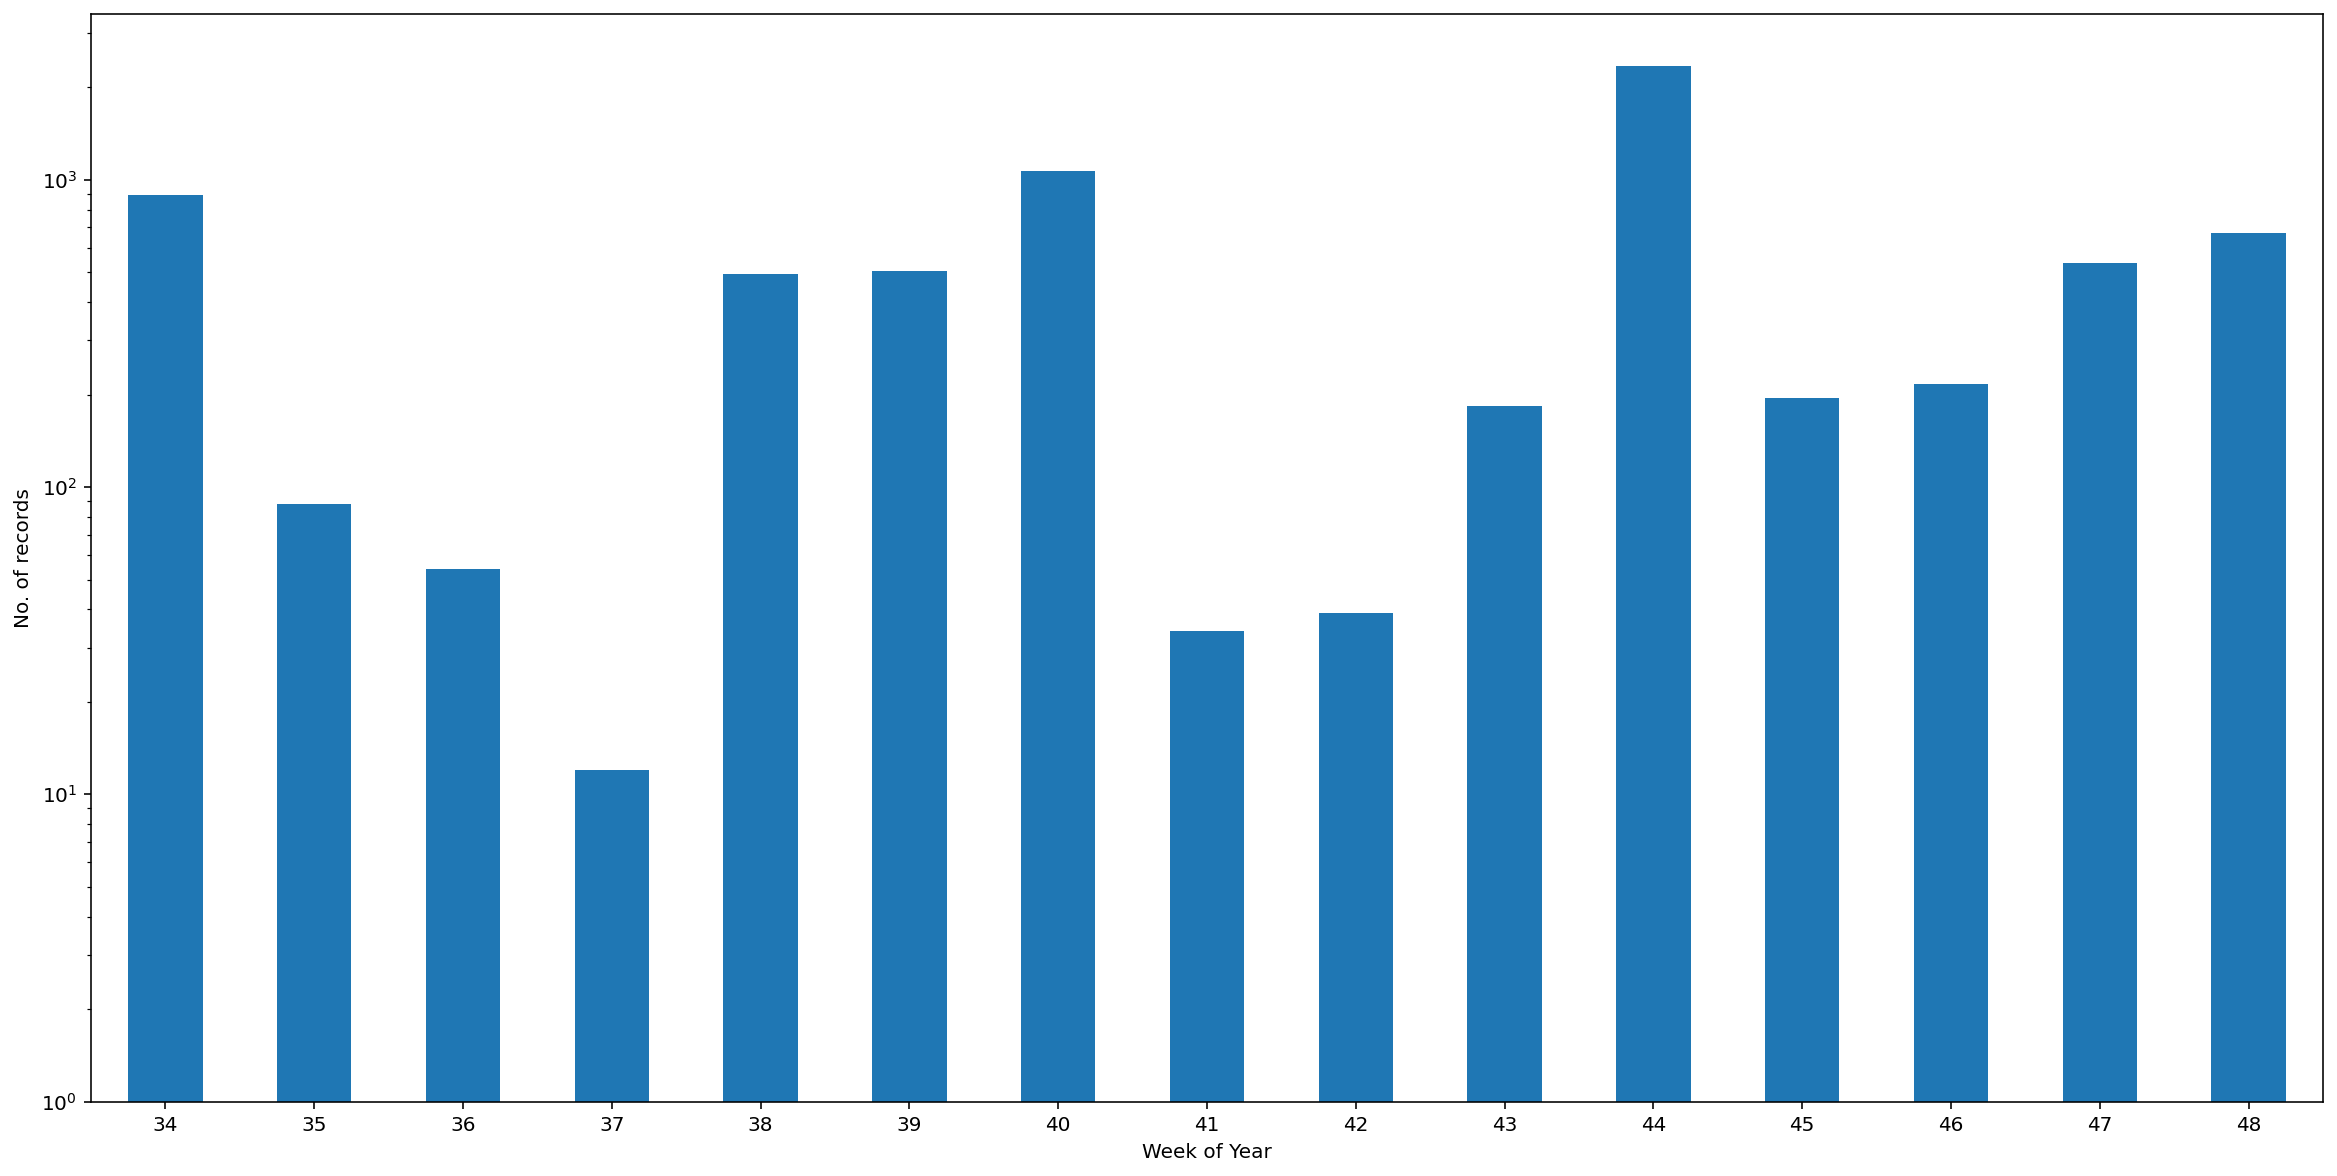

In [ ]:
tmp_freq_activity = RAW_ACTIVITY_DF.groupby(RAW_ACTIVITY_DF.sent_time.dt.isocalendar().week).size()
tmp_freq_activity.plot.bar(log=True, xlabel="Week of Year",  ylabel="No. of records",  figsize=(20, 10), rot=0)

In [ ]:
act2abbr, abbr2act = get_shorten_indices(RAW_ACTIVITY_DF)
take_from_dict(1, act2abbr)

[('Code_Contribution_Greg_Kroah-Hartman_unknown', 'CCGKU')]

In [ ]:
all_activities, unique_activities, n_unique_activities, act2idx, idx2act = unpack_activity_data_frame(RAW_ACTIVITY_DF)
# SANITY CHECK: we should expect ~290+ unique activities
assert len(RAW_ACTIVITY_DF['triplet_two'].unique()) == n_unique_activities

In [ ]:
time_frame_skipgrams, T = time_frame_weekly_split(RAW_ACTIVITY_DF)

- DataFrame partition for week 34 has 894-records.
- DataFrame partition for week 34 has 32-unique activities.
- DataFrame partition for week 35 has 87-records.
- DataFrame partition for week 35 has 14-unique activities.
- DataFrame partition for week 36 has 53-records.
- DataFrame partition for week 36 has 19-unique activities.
- DataFrame partition for week 37 has 11-records.
- DataFrame partition for week 37 has 1-unique activities.
- DataFrame partition for week 38 has 494-records.
- DataFrame partition for week 38 has 32-unique activities.
- DataFrame partition for week 39 has 503-records.
- DataFrame partition for week 39 has 31-unique activities.
- DataFrame partition for week 40 has 1071-records.
- DataFrame partition for week 40 has 37-unique activities.
- DataFrame partition for week 41 has 33-records.
- DataFrame partition for week 41 has 4-unique activities.
- DataFrame partition for week 42 has 38-records.
- DataFrame partition for week 42 has 14-unique activities.
- DataF

WEEK 34: all=554850, unique=270 skipgrams
WEEK 35: all=2049, unique=54 skipgrams
WEEK 36: all=937, unique=139 skipgrams
WEEK 37: all=121, unique=1 skipgrams
WEEK 38: all=128406, unique=408 skipgrams
WEEK 39: all=161983, unique=271 skipgrams
WEEK 40: all=864367, unique=437 skipgrams
WEEK 41: all=891, unique=12 skipgrams
WEEK 42: all=368, unique=82 skipgrams
WEEK 43: all=10703, unique=576 skipgrams
WEEK 44: all=3877890, unique=546 skipgrams
WEEK 45: all=7494, unique=409 skipgrams
WEEK 46: all=7000, unique=321 skipgrams
WEEK 47: all=50349, unique=1295 skipgrams
WEEK 48: all=434390, unique=101 skipgrams


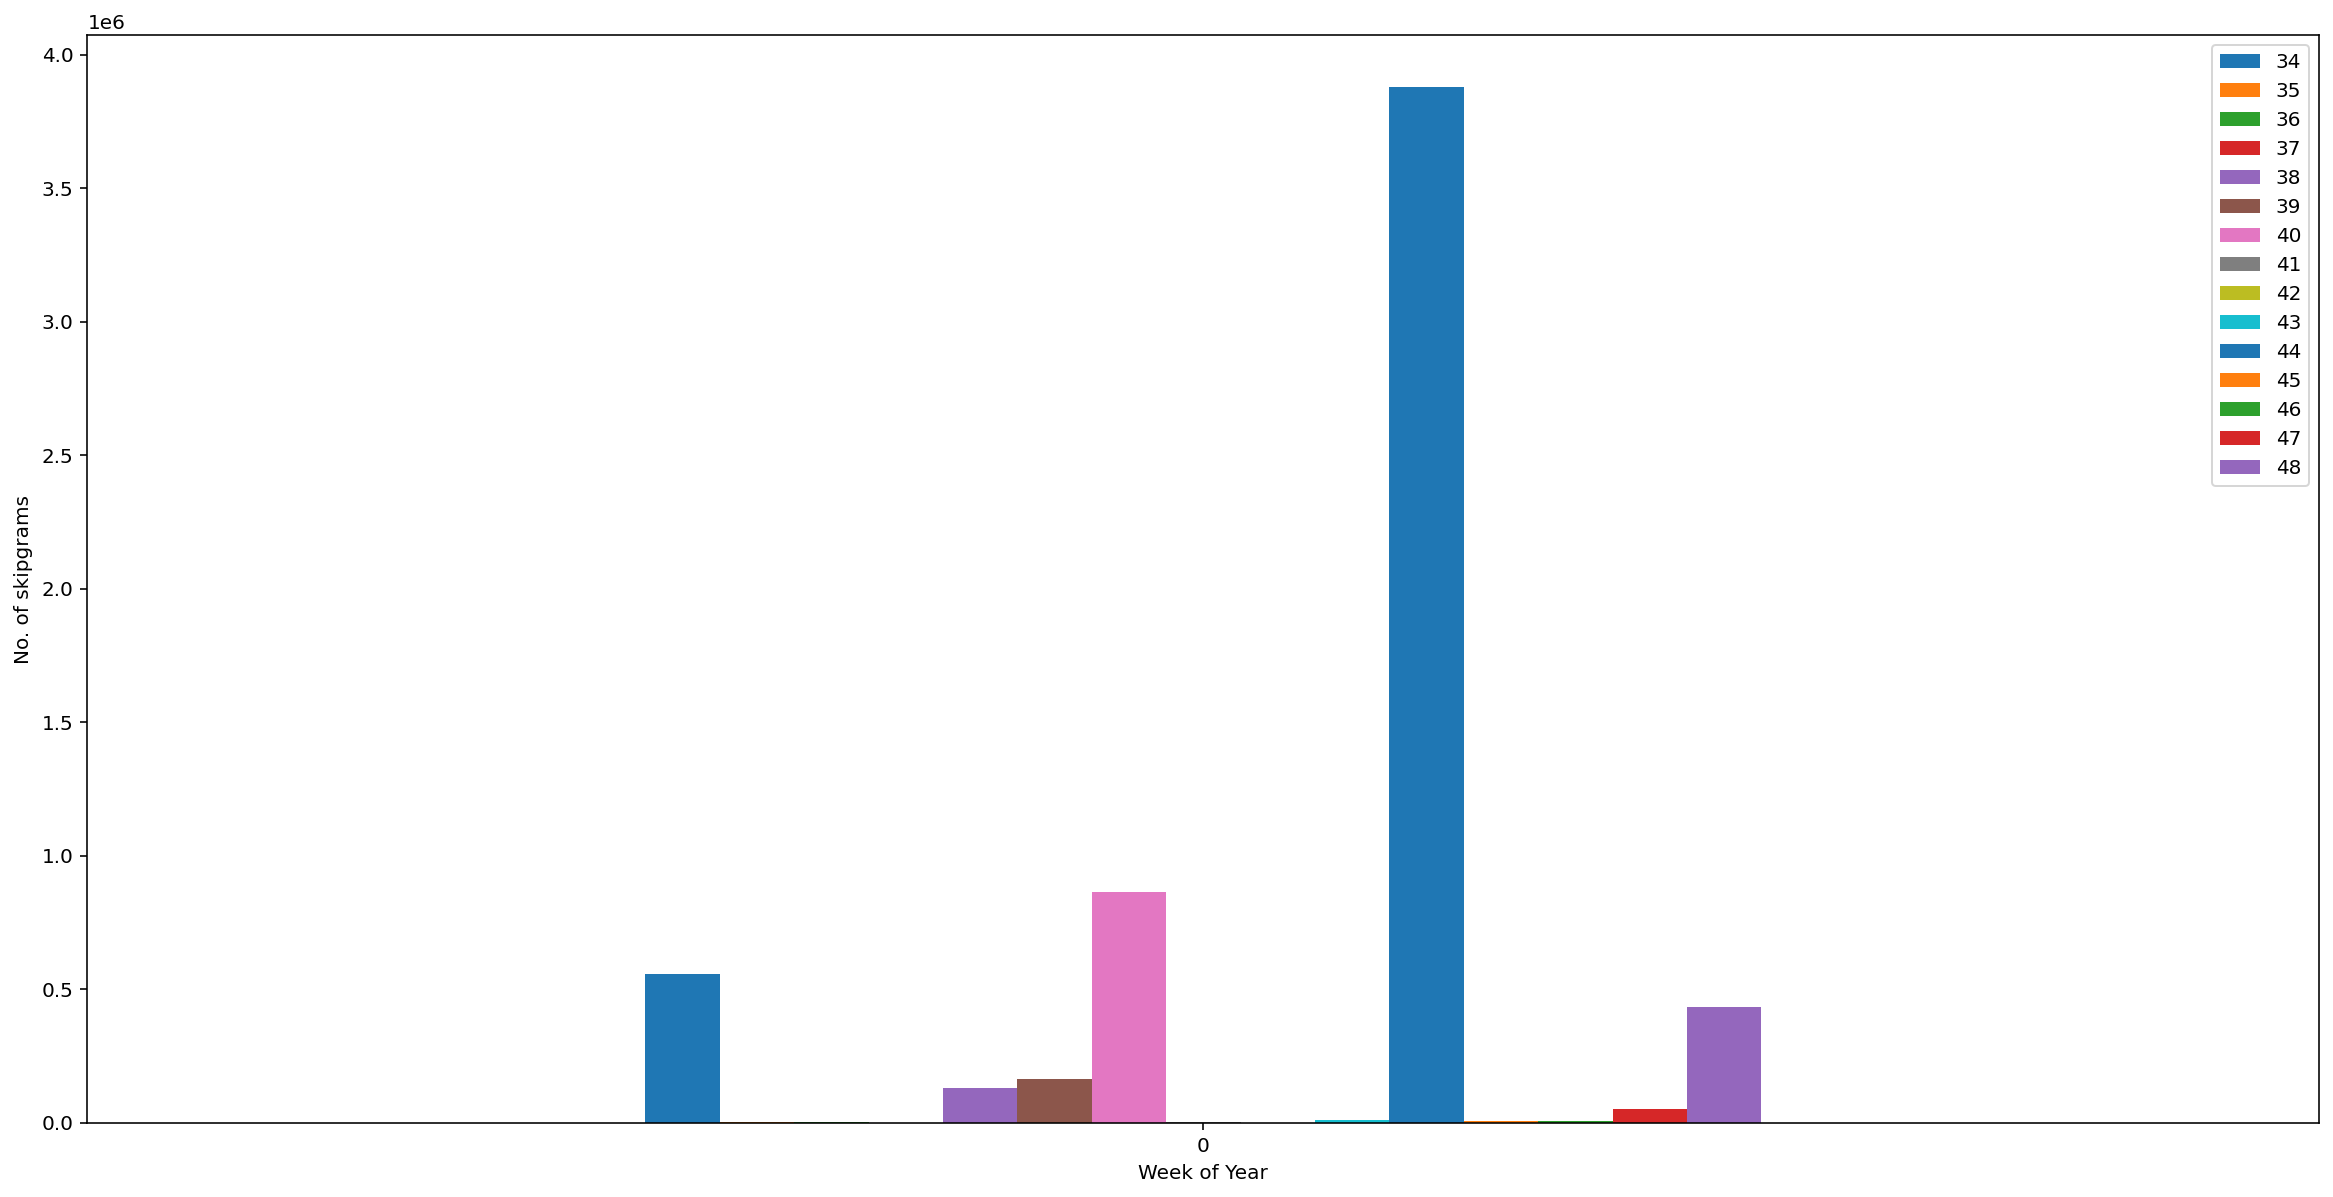

In [ ]:
describe_time_frame(time_frame_skipgrams, T, plot_skipgram_distribution=True)

In [ ]:
# Show first skipgram record of time frame = Week 34;
# It should be Greg's activity skipgram
time_frame_skipgrams[0][:1]

[('Code_Contribution_Greg_Kroah-Hartman_unknown',
  'Code_Contribution_Greg_Kroah-Hartman_unknown')]

In [ ]:
train_test_by_week = get_train_test_by_week(time_frame_skipgrams, T, act2idx)

 train_data: 215, test_data: 93 for week = 34
 train_data: 45, test_data: 20 for week = 35
 train_data: 119, test_data: 51 for week = 36
 train_data: 84, test_data: 37 for week = 37
 train_data: 290, test_data: 125 for week = 38
 train_data: 240, test_data: 103 for week = 39
 train_data: 316, test_data: 136 for week = 40
 train_data: 13, test_data: 6 for week = 41
 train_data: 57, test_data: 25 for week = 42
 train_data: 403, test_data: 173 for week = 43
 train_data: 423, test_data: 182 for week = 44
 train_data: 288, test_data: 124 for week = 45
 train_data: 224, test_data: 97 for week = 46
 train_data: 915, test_data: 393 for week = 47
 train_data: 70, test_data: 31 for week = 48


In [ ]:
# train_test_by_week[0][0][:1]
train_test_by_week[0][0][:3]

[(tensor([211, 211]), tensor([211, 211])),
 (tensor([211, 211]), tensor([211, 211])),
 (tensor([205, 211]), tensor([209, 211]))]

In [ ]:
# defining the Dataset class
class SkipgramData(Dataset):
  def __init__(self, skipgram_data):
    self.data = skipgram_data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    return self.data[index]

In [ ]:
def setup_train_test_dataloaders_per_week(train_test_by_week, weeks_in_window_range, batch_size=10):
  train_test_dataloaders_by_week = []
  for week in weeks_in_window_range:
    train_w, test_w = train_test_by_week[weeks_in_window_range.index(week)]

    train_dataset = SkipgramData(train_w)
    test_dataset  = SkipgramData(test_w)

    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    train_test_dataloaders_by_week.append((train_data_loader, test_data_loader))
  return train_test_dataloaders_by_week

train_test_dataloaders_by_week = setup_train_test_dataloaders_per_week(train_test_by_week, T)

In [ ]:
take_from_data_loader(1, T.index(47), train_test_dataloaders_by_week)

[[tensor([[ 63,  57],
          [ 63,  80],
          [ 63,  63],
          [ 63, 264],
          [ 63,  63],
          [ 93,  63],
          [274, 268],
          [ 63, 122],
          [ 63, 211],
          [ 63, 235]]), tensor([[ 63,  63],
          [ 63,  80],
          [ 63, 159],
          [ 63, 273],
          [ 63,  63],
          [231,  63],
          [274, 211],
          [ 63,  63],
          [ 63, 211],
          [ 63, 268]])]]

# 🔥 Activity Skipgram Model with Pytorch

Adaptation of the Skipgram version of Word2Vec to genarate temporal activity embeddings, based on earlier time-aware skip grams.

In [ ]:
class SkipGramModel(nn.Module):
  def __init__(self, acts_size, embedding_size):
    super(SkipGramModel, self).__init__()
    self.embedding = nn.Embedding(acts_size, embedding_size)
    self.W = nn.Linear(embedding_size, embedding_size, bias=False) 
    self.WT = nn.Linear(embedding_size, acts_size, bias=False)

  def forward(self, X):
    embeddings = self.embedding(X)
    hidden_layer = nn.functional.relu(self.W(embeddings)) 
    output_layer = self.WT(hidden_layer)
    return output_layer

In [ ]:
def get_activity_emdedding(skipgram_model, target_activity, act2idx):
  if target_activity not in act2idx:
    raise ValueError(f"{target_activity} not in activity index")
  act_vec = torch.tensor([act2idx[target_activity]])
  return skipgram_model.embedding(act_vec).view(1,-1)

In [ ]:
def plot_act_embeddings(activities, model, a2a=act2abbr, a2i=act2idx, figsize=(15,10)):
  plt.figure(figsize=figsize)

  for activity in activities:
    x = get_activity_emdedding(model, activity, a2i).detach().data.numpy()[0][0]
    y = get_activity_emdedding(model, activity, a2i).detach().data.numpy()[0][1]
    plt.scatter(x, y)
    activity_label = a2a[activity] if activity in a2a else activity
    plt.annotate(activity_label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
  plt.show()

## 💻 Define Training and Testing Procedures

Before we can actually execute the model,
we need to define the training procedure that uses those values

In [ ]:
# Hyper
EMBEDDING_SIZE = 120
LEARNING_RATE = 0.001

accelerator = Accelerator()

In [ ]:
accelerator_config_week = []
for week in T:
  train_data_loader_by_week, test_data_loader_by_week = train_test_dataloaders_by_week[T.index(week)]
  model = SkipGramModel(n_unique_activities, EMBEDDING_SIZE)
  model, optimizer, train_data, test_data = accelerator.prepare(
      model, 
      optim.Adam(model.parameters(), lr=LEARNING_RATE), 
      train_data_loader_by_week, 
      test_data_loader_by_week)

  accelerator_config_week.append((model, optimizer, train_data, test_data))

In [ ]:
len(accelerator_config_week)

15

In [ ]:
def train_fn(model, train_data_loader, optimizer, criterion, epoch, accelerator):
  model.train()
  fin_loss = 0.0
  tk = tqdm(
      train_data_loader,
      desc=" EPOCH" + " [TRAIN] " + str(epoch + 1),
      disable=not accelerator.is_local_main_process,
  )

  total_samples = None
  for t, data in enumerate(tk):
    epoch_loss = 0
    if total_samples is None:
      total_samples = len(data[0])
    for (x, y) in zip(data[0], data[1]):
      optimizer.zero_grad()
      out = model(x)
      loss = criterion(out, y)
      accelerator.backward(loss)
      optimizer.step()
      epoch_loss += loss.item()
      
      tk.set_postfix({
          "loss": "%.6f" % float(epoch_loss / (t + 1)),
          "LR": optimizer.param_groups[0]["lr"],
      })
    fin_loss += (epoch_loss * total_samples)
  

  return fin_loss / (len(train_data_loader) * total_samples), optimizer.param_groups[0]["lr"]

In [ ]:
def test_fn(model, test_data_loader, criterion, epoch, accelerator):
  model.eval()
  fin_loss = 0.0
  correct_ct = 0
  tk = tqdm(
      test_data_loader,
      desc=" EPOCH" + " [TEST] " + str(epoch + 1),
      disable=not accelerator.is_local_main_process,
  )

  total_samples = None
  with torch.no_grad():
    for t, data in enumerate(tk):
      epoch_loss = 0
      if total_samples is None:
        total_samples = len(data[0])
      for (x, y) in zip(data[0], data[1]):
        out = model(x)
        loss = criterion(out, y)
        epoch_loss += loss.item()

        _, predicted = torch.max(out, 1)
        if predicted[0] == y[0]:
          correct_ct += 1
        

        tk.set_postfix({
            "loss": "%.6f" % float(epoch_loss / (t + 1)),
            "acc": "%.6f" % float((correct_ct / (t + 1)) * 1.0 * total_samples),
        })
      fin_loss += (epoch_loss * total_samples)
    
    return fin_loss / (len(test_data_loader) * total_samples), (correct_ct/(len(test_data_loader) * total_samples))*100

## 👟 Run the Activity Skipgram Model

💪 Run this model to train a simple but effective neural network to generate activity embeddings, using the accelerator API.

In [ ]:
NUMBER_EPOCHS = 20

In [ ]:
trained_model_by_week, metrics = [], []
for week in T:
  accelerator.print(f"WEEK = {week}")
  model, optimizer, train_data, test_data = accelerator_config_week[T.index(week)]
  for epoch in range(NUMBER_EPOCHS):
    criterion = nn.CrossEntropyLoss()

    avg_loss_train_week, lr = train_fn(model, train_data, optimizer, criterion, epoch, accelerator)
    avg_loss_eval_week, acc = test_fn(model, test_data, criterion, epoch, accelerator)

    metrics.append((epoch, avg_loss_train_week, avg_loss_eval_week, lr, acc))

  trained_model_by_week.append(model)

print("Done")

WEEK = 34


 EPOCH [TEST] 20: 100%|██████████| 10/10 [00:00<00:00, 55.98it/s, loss=0.003763, acc=89.000000]


WEEK = 35


 EPOCH [TEST] 20: 100%|██████████| 2/2 [00:00<00:00, 54.96it/s, loss=9.209406, acc=75.000000]


WEEK = 36


 EPOCH [TEST] 20: 100%|██████████| 6/6 [00:00<00:00, 64.76it/s, loss=0.141240, acc=21.666667]


WEEK = 37


 EPOCH [TEST] 20: 100%|██████████| 4/4 [00:00<00:00, 59.76it/s, loss=0.000056, acc=92.500000]


WEEK = 38


 EPOCH [TEST] 20: 100%|██████████| 13/13 [00:00<00:00, 55.59it/s, loss=0.248876, acc=77.692308]


WEEK = 39


 EPOCH [TEST] 20: 100%|██████████| 11/11 [00:00<00:00, 57.95it/s, loss=0.004657, acc=87.272727]


WEEK = 40


 EPOCH [TEST] 20: 100%|██████████| 14/14 [00:00<00:00, 54.10it/s, loss=0.199803, acc=95.000000]


WEEK = 41


 EPOCH [TEST] 20: 100%|██████████| 1/1 [00:00<00:00, 90.26it/s, loss=5.808333, acc=30.000000]


WEEK = 42


 EPOCH [TEST] 20: 100%|██████████| 3/3 [00:00<00:00, 63.74it/s, loss=4.203850, acc=40.000000]


WEEK = 43


 EPOCH [TEST] 20: 100%|██████████| 18/18 [00:00<00:00, 54.48it/s, loss=0.194411, acc=51.111111]


WEEK = 44


 EPOCH [TEST] 20: 100%|██████████| 19/19 [00:00<00:00, 55.36it/s, loss=0.001123, acc=93.684211]


WEEK = 45


 EPOCH [TEST] 20: 100%|██████████| 13/13 [00:00<00:00, 56.72it/s, loss=1.003083, acc=50.000000]


WEEK = 46


 EPOCH [TEST] 20: 100%|██████████| 10/10 [00:00<00:00, 55.79it/s, loss=0.972397, acc=50.000000]


WEEK = 47


 EPOCH [TEST] 20: 100%|██████████| 40/40 [00:00<00:00, 53.81it/s, loss=0.074883, acc=61.250000]


WEEK = 48


 EPOCH [TEST] 20: 100%|██████████| 4/4 [00:00<00:00, 70.66it/s, loss=0.009927, acc=77.500000]

Done


In [ ]:
def get_model(week_idx, trained_model_by_week):
  return trained_model_by_week[week_idx]

In [ ]:
# Report average results
for week in T:
  week_idx = T.index(week)
  (epoch, avg_loss_train_week, avg_loss_eval_week, lr, acc) = metrics[week_idx]
  print(f"EPOCH = {epoch} | TRAIN_LOSS = {avg_loss_train_week} | TEST_LOSS = {avg_loss_eval_week} | TEST_ACC = {acc}")

EPOCH = 0 | TRAIN_LOSS = 4.403158952418545 | TEST_LOSS = 2.061103194858879 | TEST_ACC = 89.0
EPOCH = 1 | TRAIN_LOSS = 1.0945664685304193 | TEST_LOSS = 1.5979989796876908 | TEST_ACC = 89.0
EPOCH = 2 | TRAIN_LOSS = 0.7380643278910693 | TEST_LOSS = 1.6388693831861019 | TEST_ACC = 89.0
EPOCH = 3 | TRAIN_LOSS = 0.8157714947063307 | TEST_LOSS = 1.6315143130719663 | TEST_ACC = 89.0
EPOCH = 4 | TRAIN_LOSS = 0.7338717983114872 | TEST_LOSS = 1.8189519822597504 | TEST_ACC = 89.0
EPOCH = 5 | TRAIN_LOSS = 0.7248152401298285 | TEST_LOSS = 1.699872737750411 | TEST_ACC = 89.0
EPOCH = 6 | TRAIN_LOSS = 0.7681915043345229 | TEST_LOSS = 1.6704744922928512 | TEST_ACC = 89.0
EPOCH = 7 | TRAIN_LOSS = 0.7644817681813781 | TEST_LOSS = 1.6332847183570265 | TEST_ACC = 89.0
EPOCH = 8 | TRAIN_LOSS = 0.7133082458961078 | TEST_LOSS = 1.6541428649332375 | TEST_ACC = 89.0
EPOCH = 9 | TRAIN_LOSS = 0.6934700179051354 | TEST_LOSS = 1.7849666667170823 | TEST_ACC = 89.0
EPOCH = 10 | TRAIN_LOSS = 0.7655243627113205 | TEST_L

The above summaries show a very good performance (i.e., **89%**) of our Skipgram model for developer activity. 

Next, we show the embedding space of developer activities. For sake of presentation, the long activity names were replaced by a shorter version. E.g., a `Code_Contribution_John_Doe_Stringy` would be abbreviated as `CCJDS`.

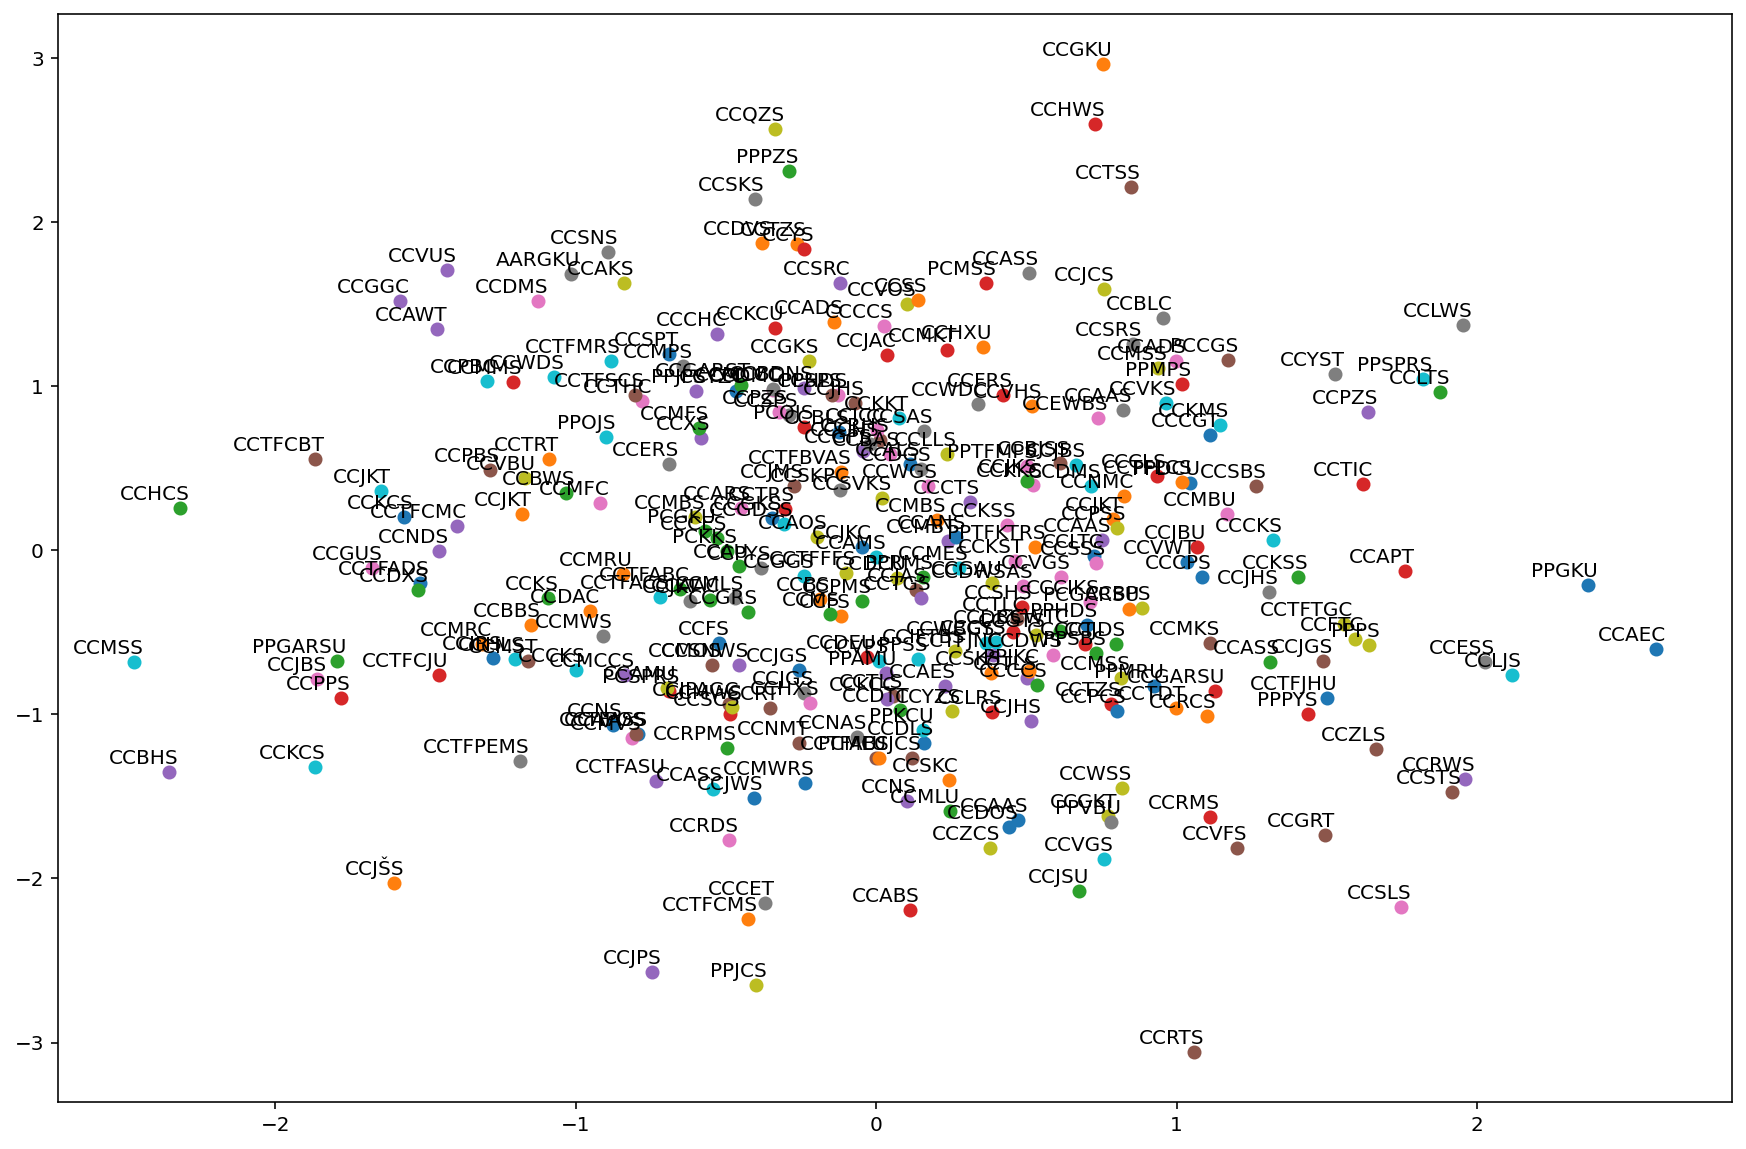

In [ ]:
# Example 1 (full activity names are shorten to facilitate plotting)
plot_act_embeddings(unique_activities, get_model(T.index(34), trained_model_by_week))

## 🚀 Post processing of dense vectors

In [ ]:
from sklearn.decomposition import PCA

def all_but_the_top(v, n_principal_components=10):
  # thx to https://gist.github.com/lgalke/febaaa1313d9c11f3bc8240defed8390
  # All-but-the-Top: Simple and Effective Postprocessing for Word Representations
  # Paper: https://arxiv.org/abs/1702.01417
  
  # 1. Subtract mean vector
  v_tilde = v - np.mean(v, axis=0)
  
  # 2. Compute the first 'n' principal components
  #    on centered embedding vectors
  u = PCA(n_components=n_principal_components).fit(v_tilde).components_  # [n_principal_components, emb_size]
  
  # Subtract first 'n' principal components
  # [vocab_size, emb_size] @ [emb_size, D] @ [n_principal_components, emb_size] -> [vocab_size, emb_size]
  return v_tilde - (v @ u.T @ u)

In [ ]:
def get_activity_embeddings(activities, model, a2i=act2idx, all_but_top=False, n_principal_components=10):
  dense_vectors = []
  for activity in activities:
    dense_vectors.append(get_activity_emdedding(model, activity, a2i).detach().data.numpy()[0])
  
  dense_vectors = np.array(dense_vectors)
  if all_but_top:
    dense_vectors = all_but_the_top(dense_vectors, n_principal_components=n_principal_components)
  return dense_vectors

In [ ]:
def plot_transformed_act_embeddings(activities, postprocessed_dense_vectors, a2a=act2abbr, figsize=(15,10)):
  plt.figure(figsize=figsize)
  for idx, activity in enumerate(activities):
    x = postprocessed_dense_vectors[idx][0]
    y = postprocessed_dense_vectors[idx][1]
    plt.scatter(x, y)
    activity_label = a2a[activity] if activity in a2a else activity
    plt.annotate(activity_label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
  plt.show()

### 💥 Transform and plot embeddings

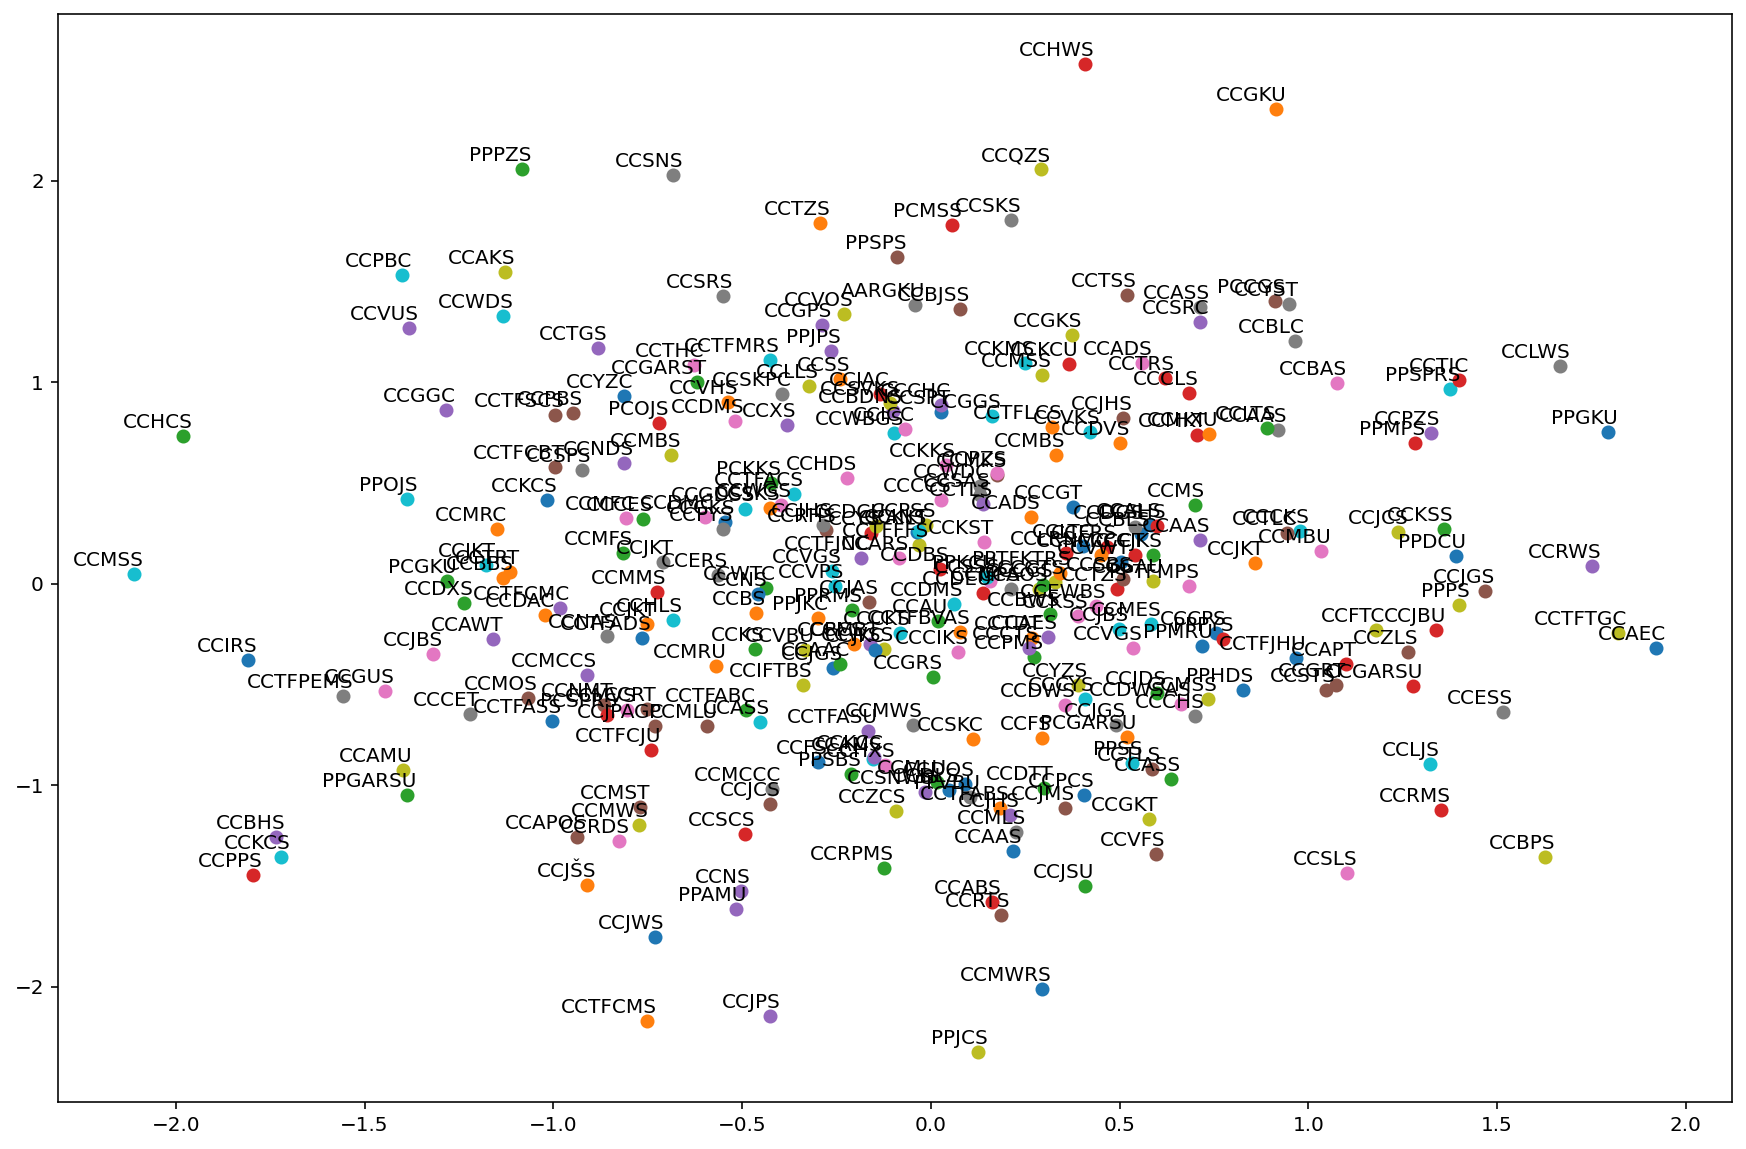

In [ ]:
# transformed embeddings for week 34
plot_transformed_act_embeddings(
    unique_activities, 
    get_activity_embeddings(
        unique_activities, 
        get_model(T.index(34), trained_model_by_week), 
        all_but_top=True, 
        n_principal_components=20))

# 👀 Tracking Activity Evolution Across Time frames 📅 

## 💪 Generate time aware embeddings

In [ ]:
def get_embedding_spaces(trained_model_by_week, weeks, unique_acts, all_but_top=False, n_principal_components=20):
  latent_spaces = []

  for week in weeks:
    latent_spaces.append(
        get_activity_embeddings(
            unique_acts, 
            get_model(T.index(week), trained_model_by_week), 
            all_but_top=all_but_top, 
            n_principal_components=n_principal_components
            )
        )

  return np.array(latent_spaces)

In [ ]:
week_aware_embs = get_embedding_spaces(trained_model_by_week, T, unique_activities, all_but_top=True)
week_aware_embs.shape

(15, 293, 120)

In [ ]:
week_aware_embs_copy = week_aware_embs.copy()

In [ ]:
from scipy.spatial import procrustes

# Aligned-Word2Vec transformation or AW2V (See Hamilton et al. 2016: Diachronic 
# Word Embeddings Reveal Statistical Laws of Semantic Change)
def aw2v(all_week_aware_embs):
  for k in range(1, len(all_week_aware_embs)):
    all_week_aware_embs[k-1], all_week_aware_embs[k], disp = procrustes(
        all_week_aware_embs[k-1],
        all_week_aware_embs[k])

  return all_week_aware_embs

In [ ]:
aligned_embs_aw2v = aw2v(week_aware_embs_copy)
aligned_embs_aw2v.shape

(15, 293, 120)

## 👉 Signal drifts and "evolution" trajectory 🚐 of selected 🤸 activities

### 📽 Visualize drifts in vector norms

In [ ]:
# Query selection

def get_random_query(n, unique_activities=None):
  if unique_activities is not None:
    return unique_activities

  indices = np.random.choice(range(len(unique_activities)), n)
  return np.array(unique_activities)[indices.astype(int)]

# hypocrite commits: ['CCGAU', 'CCAU',  'CCJBU']
# other interesting activities: ['PCKKS', 'CCRDS', 'CCSKC']
sample_query = get_random_query(2, unique_activities=[abbr2act['CCGAU'], abbr2act['CCAU'], abbr2act['CCJBU']])
sample_query

['Code_Contribution_George_Acosta_unknown',
 'Code_Contribution_Aditya_unknown',
 'Code_Contribution_James_Bond_unknown']

In [ ]:
def get_activity_norms(activity_sample, week_aware_embs, a2i=act2idx, weeks=T):
  aligned_activity_norms = []
  for act in activity_sample:
    norms = []

    for week in weeks:
      act_emb_at_week = week_aware_embs[weeks.index(week)][a2i[act], :]
      norm = np.linalg.norm(act_emb_at_week)
      norms.append(norm)
    
    norms = np.array(norms)
    norms = norms / sum(norms)
    aligned_activity_norms.append(norms)
  return aligned_activity_norms

In [ ]:
aligned_activity_norms = get_activity_norms(sample_query, aligned_embs_aw2v)
aligned_activity_norms

[array([0.07293264, 0.07075461, 0.06731931, 0.06451587, 0.07257261,
        0.06960121, 0.07168519, 0.06276137, 0.05805413, 0.06329375,
        0.06607034, 0.06866711, 0.07974927, 0.07580674, 0.03621586],
       dtype=float32),
 array([0.07387471, 0.06650762, 0.0603449 , 0.07540526, 0.06519464,
        0.07338071, 0.07391973, 0.06200419, 0.07109219, 0.07447103,
        0.0676901 , 0.05959848, 0.07657957, 0.06761459, 0.03232231],
       dtype=float32),
 array([0.06963006, 0.06779646, 0.07535993, 0.06877933, 0.06905855,
        0.07812045, 0.06208159, 0.06598337, 0.0731201 , 0.0704162 ,
        0.07000595, 0.06743637, 0.07013732, 0.05927313, 0.03280119],
       dtype=float32)]

In [ ]:
# plot activity changes (drifts from steady behavior) in the activity vector space
def plot_embedding_changes_in_vector_space(sample_query, aligned_activity_norms, weeks=T, figsize=(15,10)):
  plt.figure(figsize=figsize)
  time_frames = [week for week in weeks]
  markers = ['+', 'o', 'x']
  plt.clf()

  for idx in range(len(aligned_activity_norms)):
    norms = aligned_activity_norms[idx]
    plt.plot(time_frames, norms, marker=markers[idx], markersize=7)

  plt.legend(sample_query)
  plt.xlabel('week')
  plt.ylabel('activity norm')
  plt.show()

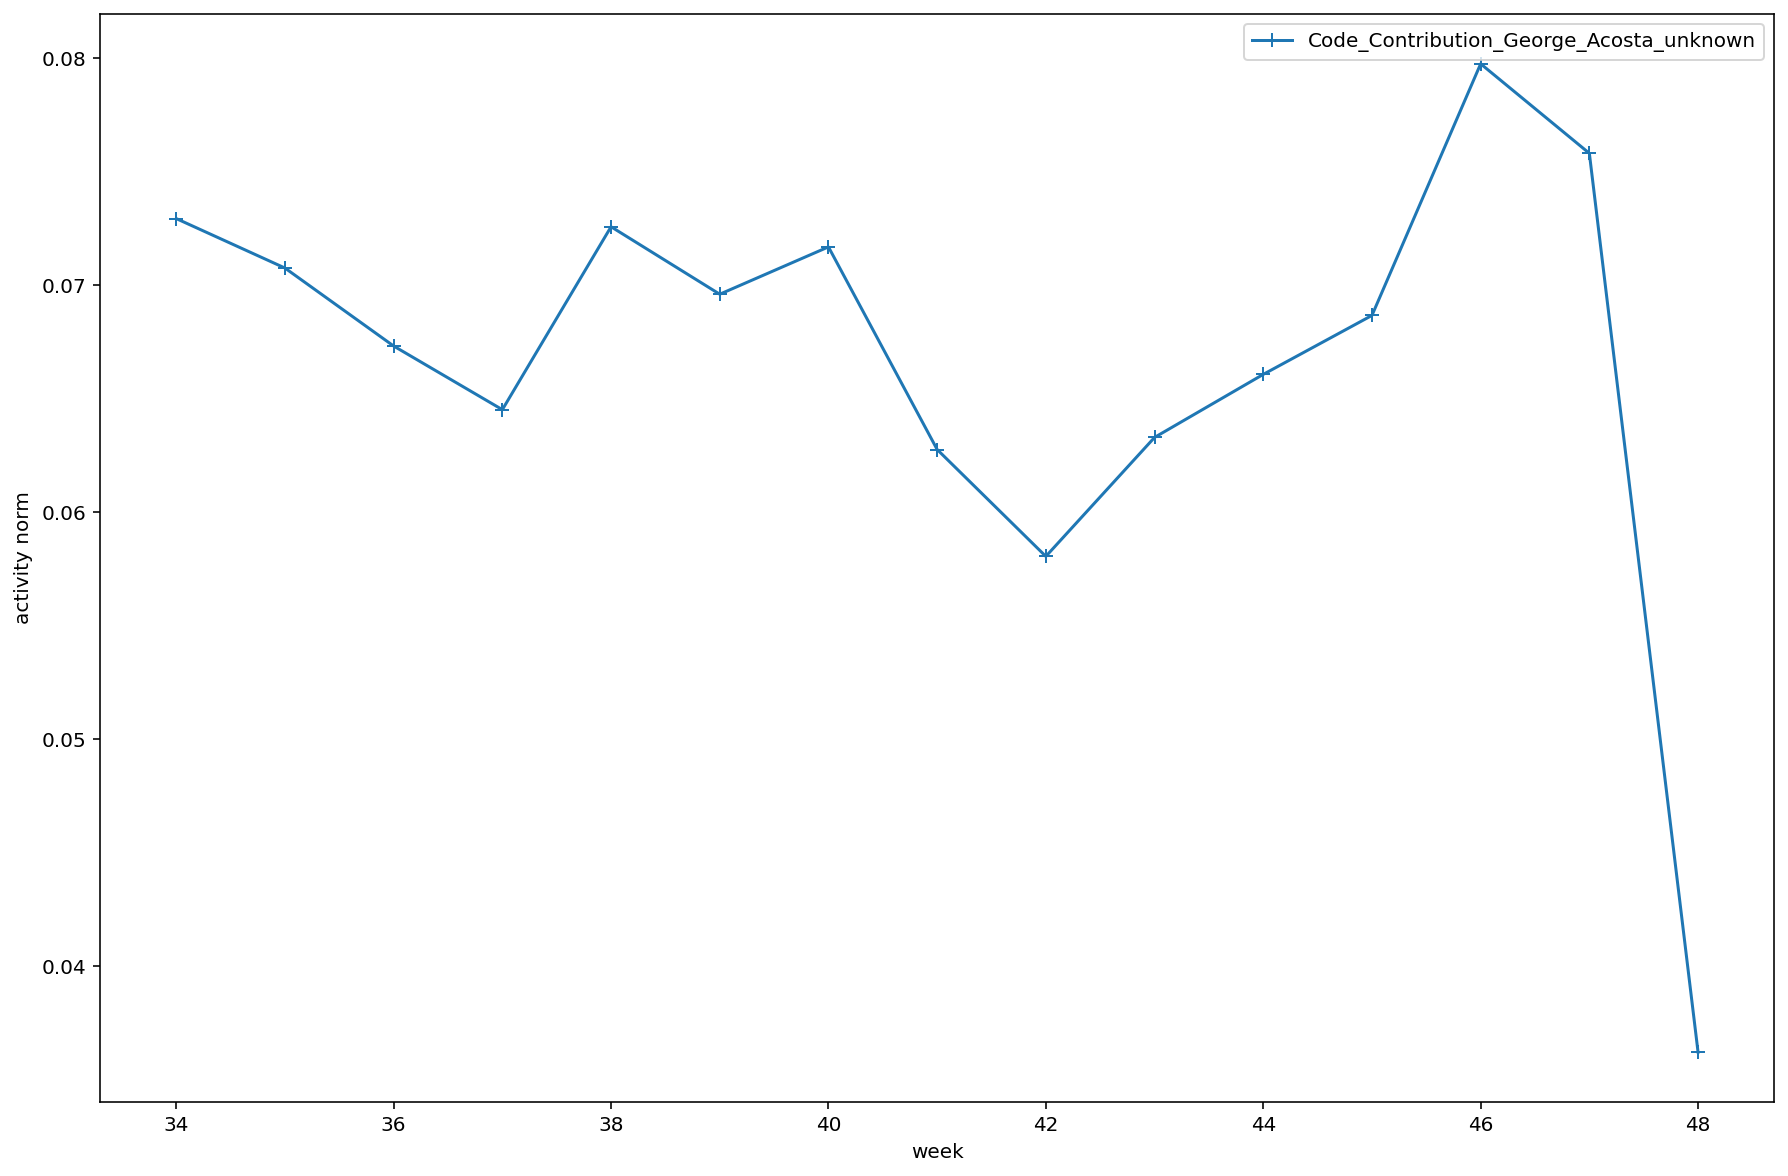

In [ ]:
plot_embedding_changes_in_vector_space(sample_query, [aligned_activity_norms[0]], weeks=T)

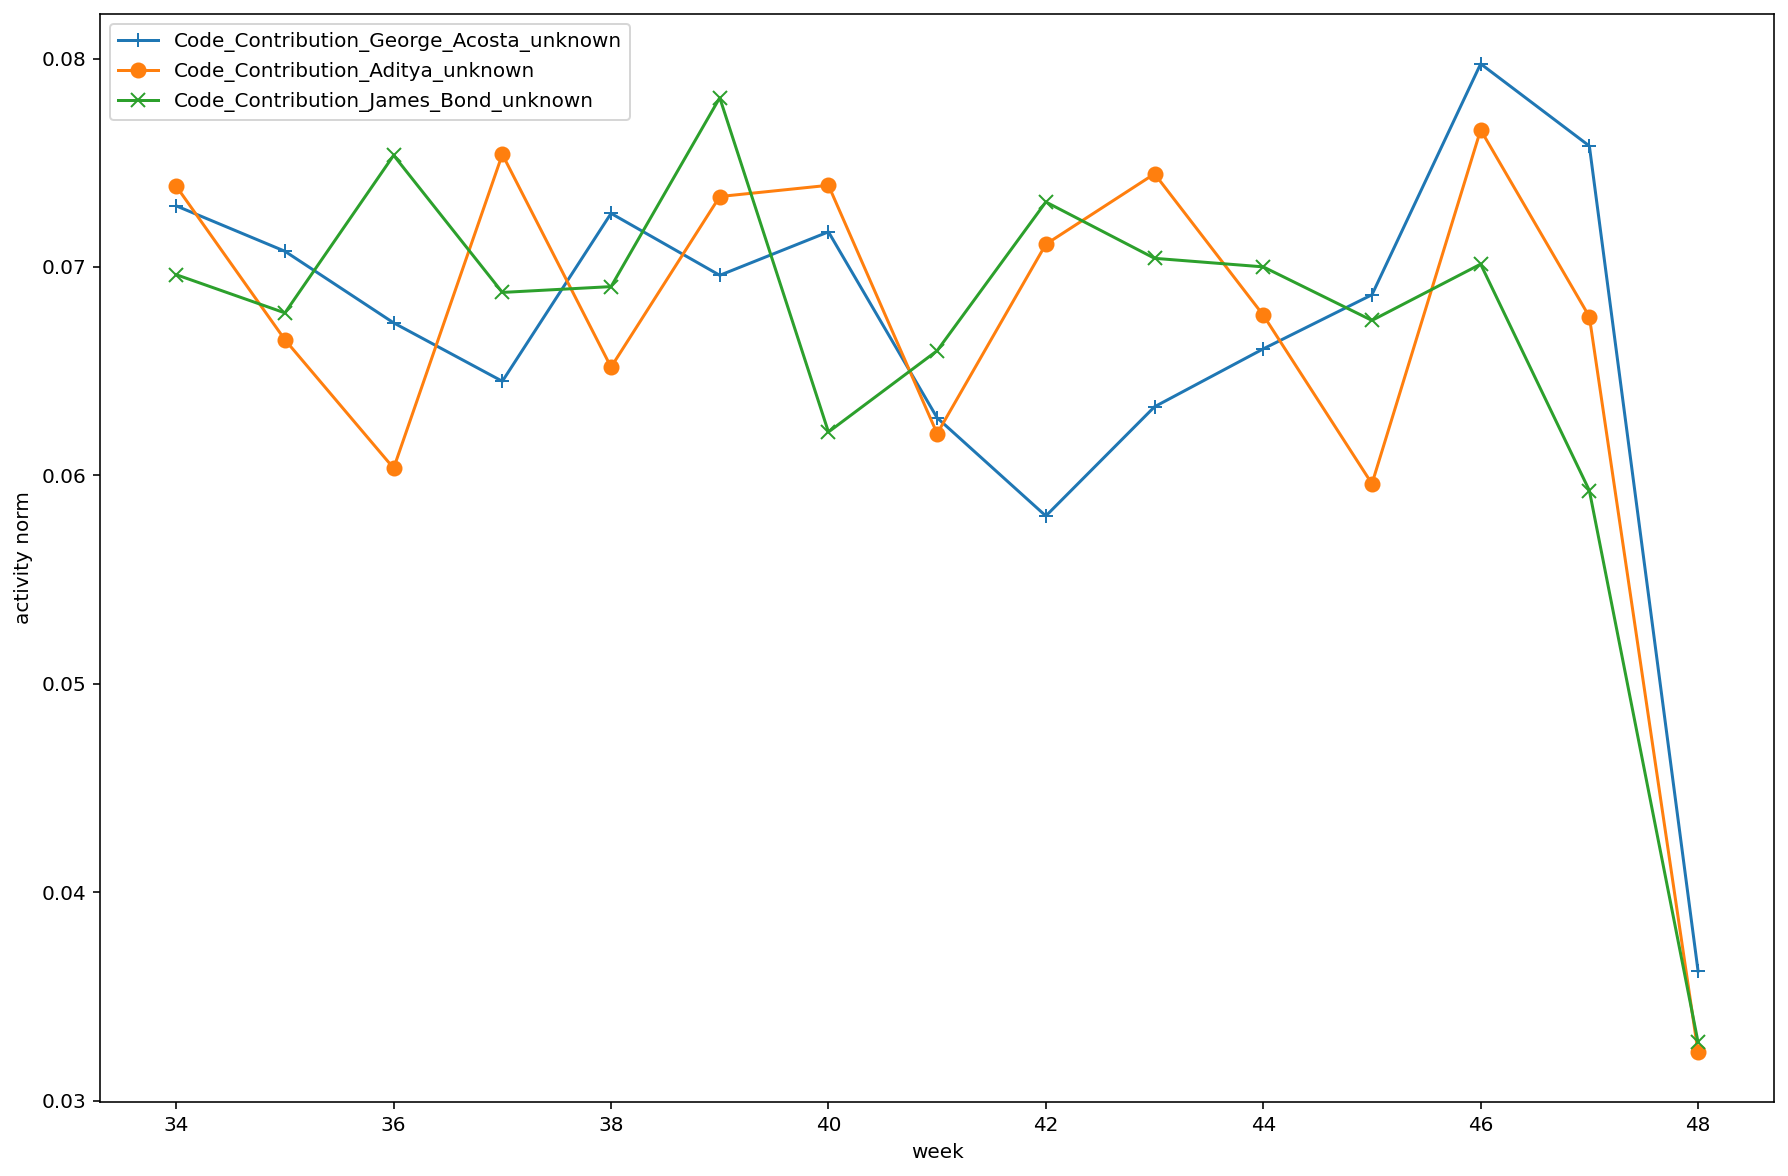

In [ ]:
# This one will plot only George's activity: plot_embedding_changes_in_vector_space(sample_query, [aligned_activity_norms[0]], weeks=T)
plot_embedding_changes_in_vector_space(sample_query, aligned_activity_norms, weeks=T)

The normal evolution of activity embeddings is expected to have a vector norm within `0.04-0.08`. Clearly, the activity embeddings of aliases used in the hyprocrite commints incident go out of this range; e.g., for George Acosta, his activities go beyond `0.10` in week `39`.

### 🐇 Follow the evolution trajectory of activities

💪 Inspired by work in tracking word evolution in NLP research (e.g., Yao et al. 2018), we focus on tracking the evolution of activities performed developers in the LKML. We partition this dataset into different time frames (e.g., weeks, months, or years) and compute time-aware embeddings for each LKML activity. Specifically, each activity in a time frame is represented by a different vector. In this context, tracking the evolution of activities refers to the changing of meanings and associations of activities throughout time, as a byproduct of developer behavior evolution. By studying activity evolution, we hope to infer behavioral trends over different periods of developer activity history in the LKML.

In [ ]:
def generate_data_needed_by_TSNE(query, emb, aligned_embs_aw2v, time_frames, act2idx, n_neighbors=30):
  X, neighbors, in_the_club = [], [], []

  v = emb[act2idx[query], :]
  for tf in time_frames:
    emb = aligned_embs_aw2v[time_frames.index(tf)]
    embnrm = np.reshape(np.sqrt(np.sum(emb**2, 1)), (emb.shape[0], 1))
    emb_normalized = np.divide(emb, np.tile(embnrm, (1, emb.shape[1])))
    
    v = emb_normalized[act2idx[query], :]
    d = np.dot(emb_normalized, v)

    idx = np.argsort(d)[::-1]
    new_acts = [(idx2act[k], tf) for k in list(idx[:n_neighbors])]
    neighbors.extend(new_acts)
    
    for k in range(n_neighbors):
      in_the_club.append(k == 0)

    X.append(emb[idx[:n_neighbors], :])

  X = np.vstack(X)
  return X, neighbors, in_the_club

In [ ]:
import warnings
warnings.filterwarnings("ignore")

def fit_TSNE_on_trajectory_data(sample_query, aligned_embs_aw2v, time_frames=T, a2i=act2idx):
  last_week_in_time_frame = 48

  query_pkg = {}
  for idx, query in enumerate(sample_query):
    emb = aligned_embs_aw2v[time_frames.index(last_week_in_time_frame)]
    X_qry, neighbors_qry, in_the_club_qry = generate_data_needed_by_TSNE(query, emb, aligned_embs_aw2v, time_frames, a2i)
    tsne_model = TSNE(n_components=2, metric = 'euclidean')
    Z_qry = tsne_model.fit_transform(X_qry)
    query_pkg[query] = (Z_qry, neighbors_qry, in_the_club_qry)
    print(f"Processed query {idx}")
  
  return query_pkg

In [ ]:
query_pkg = fit_TSNE_on_trajectory_data(sample_query, aligned_embs_aw2v)

Processed query 0
Processed query 1
Processed query 2


In [ ]:
query_pkg[take(1, sample_query)[0]][1][:3]

[('Code_Contribution_George_Acosta_unknown', 34),
 ('Code_Contribution_Julien_Desfossez_stringy', 34),
 ('Code_Contribution_Ian_Rogers_stringy', 34)]

In [ ]:
def is_relevant_activity(act, club):
  # maintainers_activities
  for mb in club:
    if mb in act:
      return True
  return False

# visualizes trajectory and marks closest activities to each
# activity in sample_query
def visualize_evolution_trajectory(query, query_pkg, unique_activities, maintainer_activities, minnesota_activities, figsize=(15,10)):
  if query not in query_pkg:
    raise ValueError(f"unknown query {query}")

  plt.figure(figsize=figsize)
  (Z, list_of_words, isword) = query_pkg[query]

  lkm = []
  traj = []
  for k, _ in enumerate(unique_activities):
    is_maintainer = False
    is_relevant = False
    if isword[k]:
      marker = 'ro'
      traj.append(Z[k, :])
      is_relevant = True
    else:
      if is_relevant_activity(list_of_words[k][0], maintainer_activities):
        marker = 'go'
        is_maintainer = True
        is_relevant = True
      elif is_relevant_activity(list_of_words[k][0], minnesota_activities):
        marker = 'mo'
        is_maintainer = False
        is_relevant = True
      else:
        marker = 'b.'
        is_maintainer = False
        # is_relevant = False
    
    alpha = None if is_relevant else 0

    plt.plot(Z[k,0], Z[k,1], marker, alpha=alpha)
    if is_maintainer:
      lkm += [list_of_words[k]]
      plt.scatter(Z[k,0], Z[k,1], s=150, color="none", edgecolor="red")

    short_label, week = shorten(list_of_words[k][0]), list_of_words[k][1]
    plt.text(Z[k,0], Z[k,1], (short_label, week), alpha=alpha)
  
  traj = np.vstack(traj)
  plt.plot(traj[:,0],traj[:,1])
  plt.show()
  return lkm

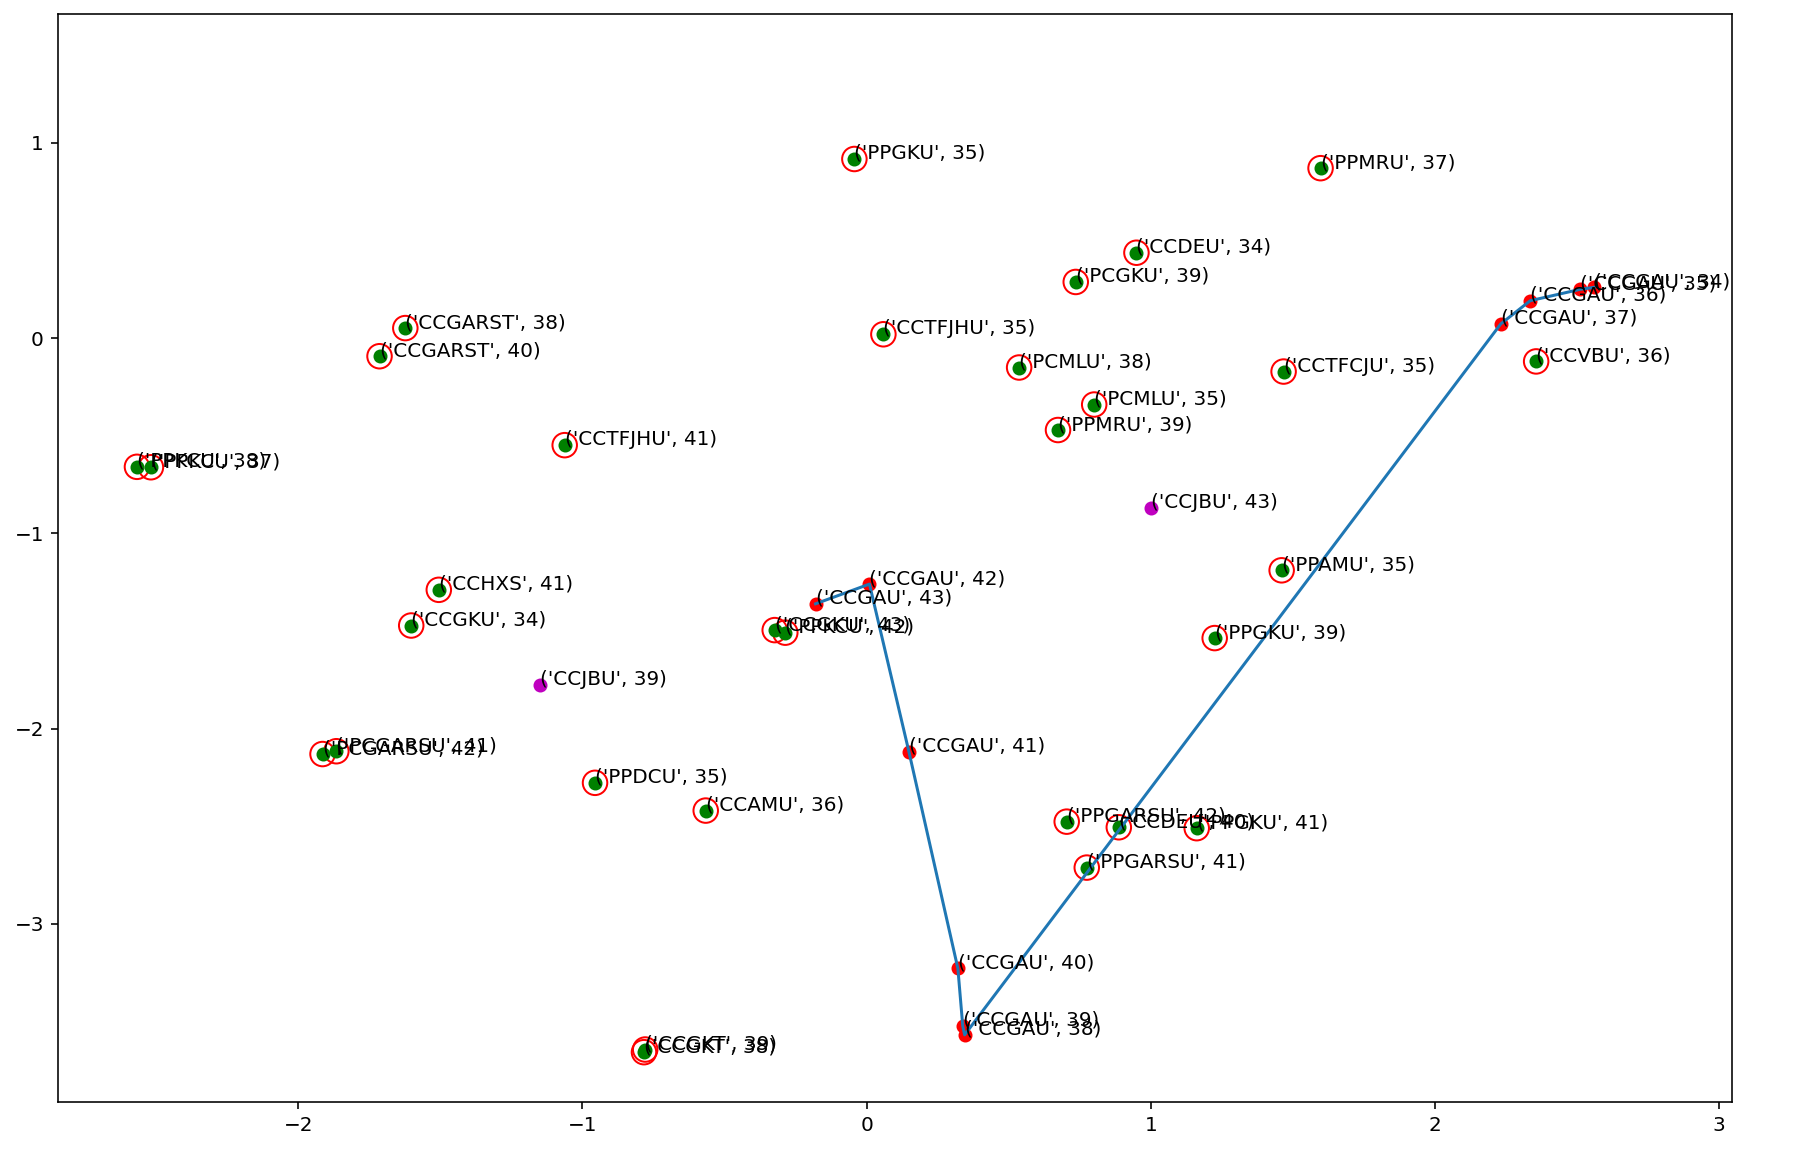

In [ ]:
lkml_for_george = visualize_evolution_trajectory('Code_Contribution_George_Acosta_unknown', query_pkg, unique_activities, linux_activities, minnesota_activities)

In [ ]:
lkml_for_george

In [ ]:
spotted_maintainers_sample = ['CCDEU', 'PPGARSU', 'PPGKU', 'PCGKU', 'CCVBU', 'CCGKT', 'CCAMU', 'AARGKU']
for sm in spotted_maintainers_sample:
  print((abbr2act[sm] if sm in abbr2act else "Unknown"))

Code_Contribution_Denis_Efremov_unknown
Patch_Posting_Gustavo_A._R._Silva_unknown
Patch_Posting_Greg_Kroah-Hartman_unknown
Progress_Control_Greg_Kroah-Hartman_unknown
Code_Contribution_Vlastimil_Babka_unknown
Code_Contribution_Greg_Kroah-Hartman_tree
Code_Contribution_Andrew_Morton_unknown
Acknowledgement_and_Response_Greg_Kroah-Hartman_unknown


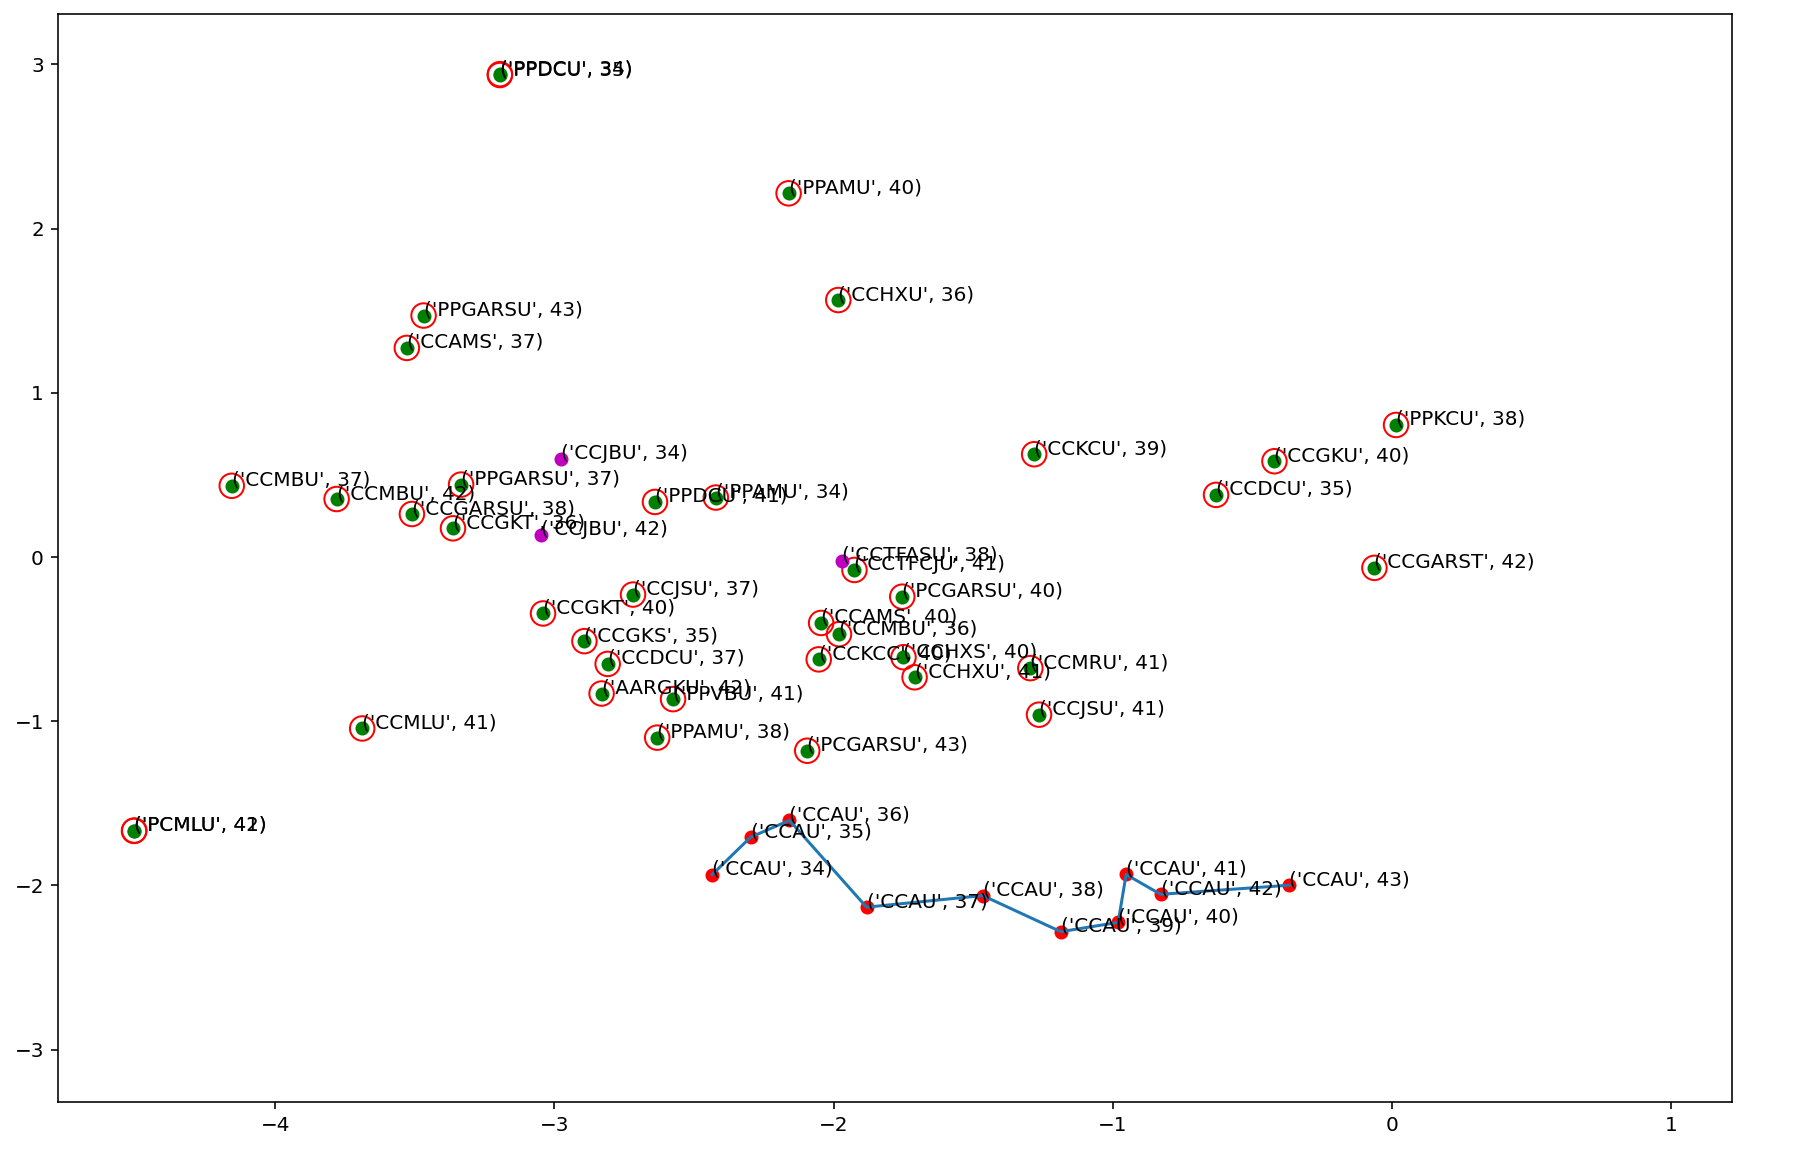

In [ ]:
visualize_evolution_trajectory('Code_Contribution_Aditya_unknown', query_pkg, unique_activities, linux_activities, minnesota_activities)

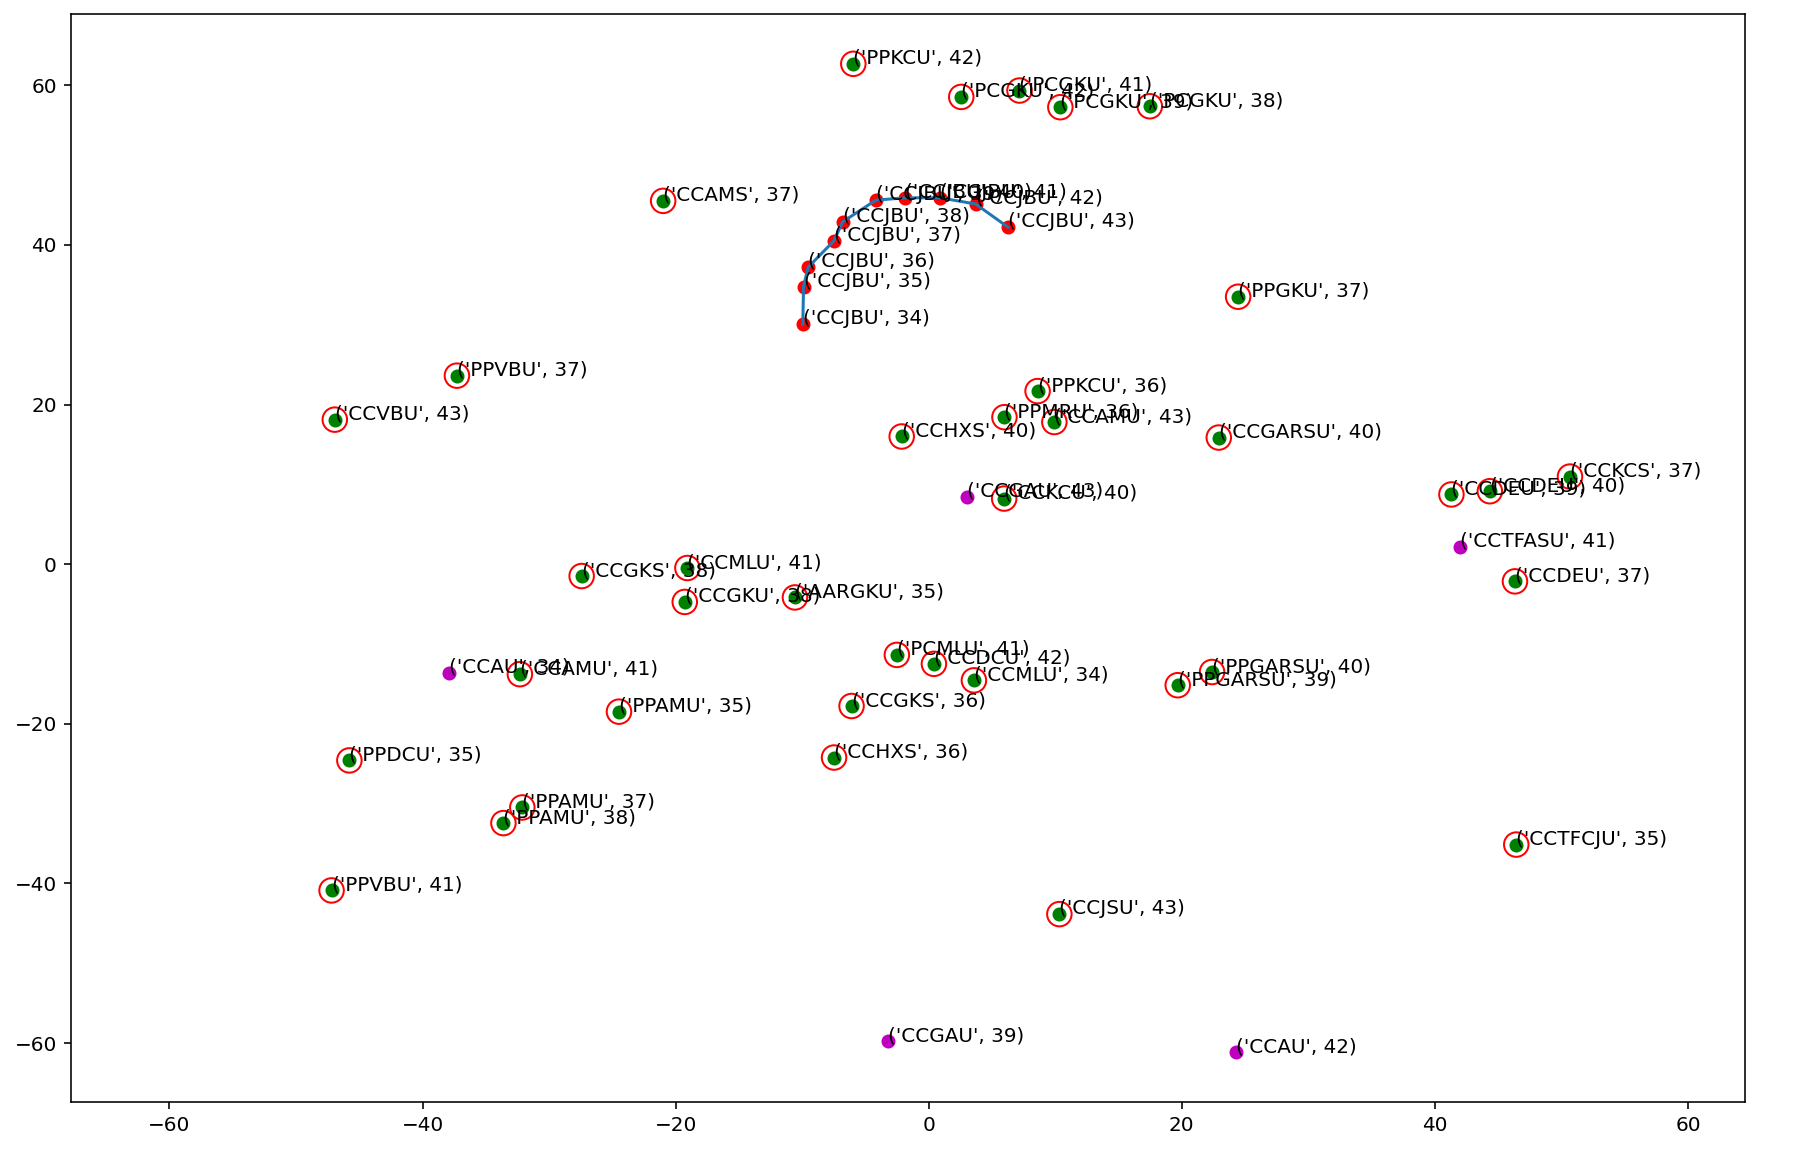

In [ ]:
visualize_evolution_trajectory('Code_Contribution_James_Bond_unknown', query_pkg, unique_activities, linux_activities, minnesota_activities)

In the above images, maintainer actions (green markers) close to hypocrite commit actions are marked with red circles. If one follows the evolution trajectory of hypocrite commits (red dot) across many weeks, one can see an increase of maintainer actions close to these hypocrite commits actions, suggesting an trust ascendancy of these actions.